# Environment setup

Scratch_CNN_2_classe_pytorch_MalinVsBenin

In [16]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'  # Tu travailles uniquement sur GPU 3

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print("✅ GPUs visibles pour TensorFlow :", gpus)


✅ GPUs visibles pour TensorFlow : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [1]:
import zipfile
import os

# Chemin du fichier ZIP
zip_path = "CBIS_DDSM_MedicalCNN.zip"  # Ton fichier zip (assure-toi qu'il est dans le dossier de travail)
output_dir = "."  # Dossier courant

# Vérification que le fichier existe
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print("✅ Décompression terminée sans renommage !")
else:
    print(f"❌ Fichier {zip_path} introuvable. Vérifiez le chemin.")


✅ Décompression terminée sans renommage !


In [3]:
# Imports classiques
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Torch : deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Dataset et DataLoader
from torch.utils.data import Dataset, DataLoader

# Scikit-learn pour les métriques
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [17]:
# 🔒 Pour des résultats reproductibles
import random
import numpy as np
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"✅ Seed fixé à {seed}")


✅ Seed fixé à 42


# Cropping images

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as F
import numpy as np

# === Charger les données
train_images, train_labels = load_training("FULL")

# === Nombre d'exemples à afficher
num_images = 5
start_index = 0  # Tu peux le changer si tu veux voir à partir d'ailleurs

# === Fonction de crop
def crop_borders(image, top=30, bottom=30, left=30, right=30):
    w, h = image.size
    return F.crop(image, top, left, h - top - bottom, w - left - right)

# === Création de la figure
plt.figure(figsize=(10, 2.5 * num_images))

for i in range(num_images):
    index = start_index + i
    img = train_images[index]
    label = train_labels[index]

    # Adapter [1, H, W] ou [H, W, 1]
    if img.ndim == 3 and img.shape[-1] == 1:
        img = np.squeeze(img, axis=-1)
    elif img.ndim == 3 and img.shape[0] == 1:
        img = np.squeeze(img, axis=0)

    img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
    img_pil = Image.fromarray(img).convert("L")
    cropped_img = crop_borders(img_pil)

    # Affichage image originale
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(img_pil, cmap="gray")
    plt.title(f"Original (Label: {label})")
    plt.axis("off")

    # Affichage image croppée
    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(cropped_img, cmap="gray")
    plt.title("Après crop")
    plt.axis("off")

plt.tight_layout()
plt.show()


NameError: name 'load_training' is not defined

In [32]:
import numpy as np
from PIL import Image
import torchvision.transforms.functional as F
import os
from tqdm import tqdm

# === Fonction de crop ===
def crop_borders_np(img, top=30, bottom=30, left=30, right=30):
    if img.ndim == 3 and img.shape[-1] == 1:
        img = np.squeeze(img, axis=-1)
    elif img.ndim == 3 and img.shape[0] == 1:
        img = np.squeeze(img, axis=0)

    img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
    pil_img = Image.fromarray(img).convert("L")

    w, h = pil_img.size
    cropped = F.crop(pil_img, top, left, h - top - bottom, w - left - right)

    cropped_np = np.array(cropped).astype(np.float32) / 255.0
    return cropped_np[..., np.newaxis]  # [H, W, 1]

# === Chargement des données originales ===
train_images, train_labels = load_training("FULL")
test_images, test_labels = load_testing("FULL")

# === Application du crop ===
print("✂️ Crop des images d'entraînement...")
cropped_train = np.array([crop_borders_np(img) for img in tqdm(train_images)])
print("✂️ Crop des images de test...")
cropped_test = np.array([crop_borders_np(img) for img in tqdm(test_images)])

# === Sauvegarde dans le dossier "image_cropped" ===
output_dir = "image_cropped"
os.makedirs(output_dir, exist_ok=True)

np.save(os.path.join(output_dir, "train_tensor.npy"), cropped_train)
np.save(os.path.join(output_dir, "train_labels.npy"), train_labels)
np.save(os.path.join(output_dir, "public_test_tensor.npy"), cropped_test)
np.save(os.path.join(output_dir, "public_test_labels.npy"), test_labels)

print(f"✅ Sauvegarde terminée dans le dossier : {output_dir}")


 21%|██▏       | 529/2482 [00:00<00:00, 5288.63it/s]

✂️ Crop des images d'entraînement...


100%|██████████| 621/621 [00:00<00:00, 6113.21it/s]


✂️ Crop des images de test...
✅ Sauvegarde terminée dans le dossier : image_cropped


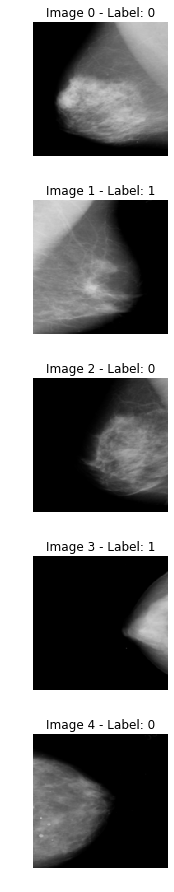

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# === Charger les images croppées
cropped_images = np.load("image_cropped/train_tensor.npy")
cropped_labels = np.load("image_cropped/train_labels.npy")

# === Nombre d'images à visualiser
num_images = 5
start_index = 0  # Tu peux changer pour voir d'autres images

# === Affichage
plt.figure(figsize=(10, 2.5 * num_images))

for i in range(num_images):
    idx = start_index + i
    img = cropped_images[idx]
    label = cropped_labels[idx]

    # Gérer [H, W, 1]
    if img.ndim == 3:
        img = np.squeeze(img)

    # Convertir pour affichage
    img = (img * 255).astype(np.uint8)
    pil_img = Image.fromarray(img).convert("L")

    plt.subplot(num_images, 1, i + 1)
    plt.imshow(pil_img, cmap="gray")
    plt.title(f"Image {idx} - Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Data pre-processing

In [18]:
import numpy as np
import os

# Définir le chemin des données
cbis_path = 'FULL_FinalClean'  # Ton dossier où tu as sauvé les .npy

def load_training(cbis_path):
    """
    Load the full training set (no skipping)
    """
    images = np.load(os.path.join(cbis_path, 'train_tensor.npy'))
    labels = np.load(os.path.join(cbis_path, 'train_labels.npy'))
    return images, labels

def load_testing(cbis_path):
    """
    Load the full test set (no skipping)
    """
    images = np.load(os.path.join(cbis_path, 'public_test_tensor.npy'))
    labels = np.load(os.path.join(cbis_path, 'public_test_labels.npy'))
    return images, labels



In [19]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# === 1. Charger les données ===
cbis_path = 'FULL_FinalClean'

def load_training(path):
    X = np.load(f"{path}/train_tensor.npy")
    y = np.load(f"{path}/train_labels.npy")
    return X, y

def load_testing(path):
    X = np.load(f"{path}/public_test_tensor.npy")
    y = np.load(f"{path}/public_test_labels.npy")
    return X, y

train_images, train_labels = load_training(cbis_path)
test_images, test_labels = load_testing(cbis_path)

# === 2. Réorganisation pour PyTorch ===
train_images = np.transpose(train_images, (0, 3, 1, 2))
test_images = np.transpose(test_images, (0, 3, 1, 2))
print(f"Train size: {train_images.shape[0]} | Test size: {test_images.shape[0]}")
print(f"Image shape: {train_images.shape[1:]}")

# === 3. Shuffle données d'entraînement ===
perm = np.random.permutation(train_images.shape[0])
train_images = train_images[perm]
train_labels = train_labels[perm]

# === 4. Dataset personnalisé ===
class MammogramDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if img.shape[0] == 1:
            img = img.squeeze(0)
        img = Image.fromarray((img * 255).astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

# === 5. Transformations ===

# ✅ Data augmentation pour entraînement
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ❄️ Pas d’augmentation pour validation/test
common_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === 6. Split en train / val ===
train_size = int(0.8 * len(train_images))
val_size = len(train_images) - train_size
train_images_split = train_images[:train_size]
train_labels_split = train_labels[:train_size]
val_images_split = train_images[train_size:]
val_labels_split = train_labels[train_size:]

# === 7. Datasets
train_dataset = MammogramDataset(train_images_split, train_labels_split, transform=train_transform)
val_dataset   = MammogramDataset(val_images_split, val_labels_split, transform=common_transform)
test_dataset  = MammogramDataset(test_images, test_labels, transform=common_transform)

# === 8. DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("✅ DataLoaders avec data augmentation pour le train prêts !")


Train size: 2482 | Test size: 621
Image shape: (1, 512, 512)
✅ DataLoaders avec data augmentation pour le train prêts !


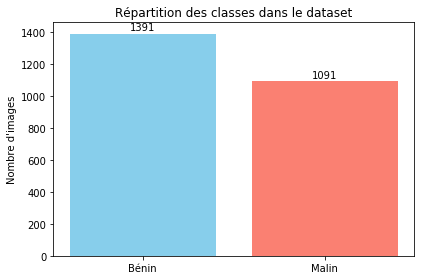

In [15]:
import matplotlib.pyplot as plt

# Remplace ces valeurs par les vraies si besoin
n_benign = (train_labels == 0).sum().item()
n_malignant = (train_labels == 1).sum().item()

labels = ['Bénin', 'Malin']
counts = [n_benign, n_malignant]

# Création du graphique
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts, color=['skyblue', 'salmon'])
plt.title("Répartition des classes dans le dataset")
plt.ylabel("Nombre d'images")

# Ajout des annotations sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

# Sauvegarde de l’image
plt.tight_layout()
plt.savefig("repartition_classes_dataset.png")
plt.show()


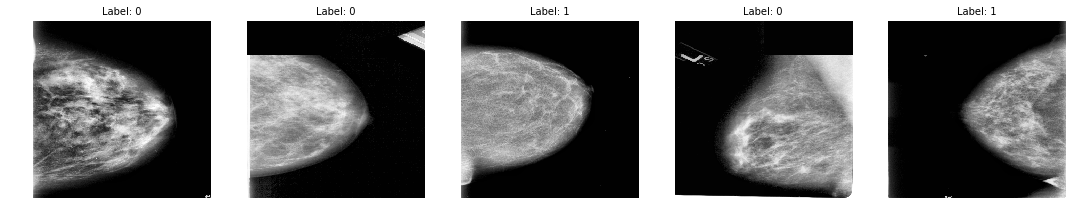

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Paramètres d'affichage
num_images = 5
cols = 5
rows = (num_images + cols - 1) // cols  # Nombre de lignes

# Création de la figure
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

# Assurer que axes est toujours une liste plate
axes = np.array(axes).reshape(-1)

for i in range(num_images):
    image = train_images[i].squeeze()  # enleve le canal s'il est inutile
    label = int(train_labels[i])

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}", fontsize=10)
    axes[i].axis('off')

# Cacher les cases en trop
for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Shape : (800, 1, 224, 224) (batch, channel, height, width)
Label shape : (800,)

Valeurs brutes (1ère image, aplatie) :
[0.487441   0.53890985 0.566876   0.5515744  0.5687066  0.5863752
 0.55682904 0.51453274 0.5149172  0.56956494]


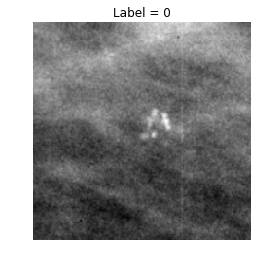

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Charger le fichier numpy
train_tensor = np.load("Numpy_Data/train_tensor.npy")
train_labels = np.load("Numpy_Data/train_labels.npy")

# Afficher la forme
print(f"Shape : {train_tensor.shape} (batch, channel, height, width)")
print(f"Label shape : {train_labels.shape}")

# Afficher les 3 premières valeurs (brut)
print("\nValeurs brutes (1ère image, aplatie) :")
print(train_tensor[0].flatten()[:10])

# Afficher l'image et son label
plt.imshow(train_tensor[0][0], cmap='gray')  # [0][0] car 1 canal
plt.title(f"Label = {train_labels[0]}")
plt.axis('off')
plt.show()


# EffeicientNetBinary

In [7]:
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EfficientNetBinary(nn.Module):
    def __init__(self, dropout_rate=0.5, fine_tune=False):
        super().__init__()
        self.base = EfficientNet.from_pretrained('efficientnet-b0')
        in_features = self.base._fc.in_features

        # 🔁 Geler tout le backbone si fine_tune=False
        if not fine_tune:
            for param in self.base.parameters():
                param.requires_grad = False

        # ✅ Remplacer la dernière couche FC avec Dropout + Linear
        self.base._fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, 1)
        )

    def forward(self, x):
        return self.base(x)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
from tqdm import tqdm
import os
import json

# 🔽 Taux de dropout utilisé
dropout_rate = 0.3

model_effnet = EfficientNetBinary(dropout_rate=dropout_rate)

# Geler toutes les couches du backbone
for param in model_effnet.base.parameters():
    param.requires_grad = False

# Garder uniquement la tête (fc) active pour l'entraînement initial
for param in model_effnet.base._fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_effnet = model_effnet.to(device)

# ⚖️ Gestion du déséquilibre
n_pos = (train_labels == 1).sum()
n_neg = (train_labels == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 🔧 Optimiseur
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_effnet.parameters()), lr=1e-4)

# 📉 Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# 📁 Dossiers de sauvegarde horodaté
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join("runs_dropout", f"effnet_b0_d{int(dropout_rate*100)}_run_{timestamp}")
model_dir = os.path.join(run_dir, "model")
log_dir = os.path.join(run_dir, "logs")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

best_model_path = os.path.join(model_dir, "best_model.pth")
final_model_path = os.path.join(model_dir, "final_model.pth")

# 📊 Historique
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# 🔁 Entraînement avec EarlyStopping + Dégel progressif
num_epochs = 50
best_val_loss = float('inf')
patience = 8
patience_counter = 0

for epoch in range(num_epochs):
    # 🔓 Dégel progressif à partir de l'epoch 5
    if epoch == 5:
        print("🔓 Fine-tuning activé : dégel des couches EfficientNet")
        for param in model_effnet.base.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model_effnet.parameters(), lr=1e-5)

    model_effnet.train()
    running_loss, correct, total = 0.0, 0, 0

    print(f"\n🟢 Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="🔄 Entraînement", leave=True):
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1, 1).float()

        optimizer.zero_grad()
        outputs = model_effnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # 📏 Validation
    model_effnet.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="📊 Validation", leave=True):
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1, 1).float()
            outputs = model_effnet(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"📈 Résumé Epoch {epoch+1} : "
          f"Train Loss = {epoch_loss:.4f}, Acc = {epoch_acc:.4f} | "
          f"Val Loss = {val_loss:.4f}, Acc = {val_acc:.4f} | "
          f"LR = {current_lr:.6f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model_effnet.state_dict(), best_model_path)
        print(f"✅ Nouveau meilleur modèle sauvegardé : {best_model_path}")
    else:
        patience_counter += 1
        print(f"⏳ Patience : {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping déclenché.")
            break

# 💾 Sauvegarde finale
torch.save(model_effnet.state_dict(), final_model_path)
print(f"📦 Modèle final sauvegardé : {final_model_path}")

# 📝 Sauvegarde logs
with open(os.path.join(log_dir, "losses.json"), "w") as f:
    json.dump({"train": train_losses, "val": val_losses}, f)

with open(os.path.join(log_dir, "metrics.json"), "w") as f:
    json.dump({"train": train_accs, "val": val_accs}, f)


Loaded pretrained weights for efficientnet-b0


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]


🟢 Epoch 1/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 1 : Train Loss = 0.7732, Acc = 0.5275 | Val Loss = 0.7791, Acc = 0.5030 | LR = 0.000100
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 2/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 2 : Train Loss = 0.7750, Acc = 0.5259 | Val Loss = 0.7747, Acc = 0.5372 | LR = 0.000100
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 3/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 3 : Train Loss = 0.7718, Acc = 0.5360 | Val Loss = 0.7711, Acc = 0.5252 | LR = 0.000100
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 4/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 4 : Train Loss = 0.7642, Acc = 0.5733 | Val Loss = 0.7696, Acc = 0.5252 | LR = 0.000100
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 5/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 5 : Train Loss = 0.7626, Acc = 0.5657 | Val Loss = 0.7725, Acc = 0.5070 | LR = 0.000100
⏳ Patience : 1/8
🔓 Fine-tuning activé : dégel des couches EfficientNet

🟢 Epoch 6/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 6 : Train Loss = 0.7561, Acc = 0.5738 | Val Loss = 0.7638, Acc = 0.5714 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 7/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 7 : Train Loss = 0.7485, Acc = 0.6131 | Val Loss = 0.7618, Acc = 0.5734 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 8/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 8 : Train Loss = 0.7465, Acc = 0.5970 | Val Loss = 0.7554, Acc = 0.5875 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 9/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 9 : Train Loss = 0.7398, Acc = 0.6207 | Val Loss = 0.7500, Acc = 0.6016 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 10/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 10 : Train Loss = 0.7250, Acc = 0.6257 | Val Loss = 0.7449, Acc = 0.6056 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 11/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 11 : Train Loss = 0.7177, Acc = 0.6408 | Val Loss = 0.7392, Acc = 0.5996 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 12/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 12 : Train Loss = 0.7161, Acc = 0.6469 | Val Loss = 0.7346, Acc = 0.6117 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 13/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 13 : Train Loss = 0.7049, Acc = 0.6438 | Val Loss = 0.7303, Acc = 0.6076 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 14/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 14 : Train Loss = 0.6993, Acc = 0.6564 | Val Loss = 0.7262, Acc = 0.6177 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 15/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 15 : Train Loss = 0.6881, Acc = 0.6625 | Val Loss = 0.7221, Acc = 0.6217 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 16/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 16 : Train Loss = 0.6827, Acc = 0.6564 | Val Loss = 0.7196, Acc = 0.6237 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 17/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 17 : Train Loss = 0.6781, Acc = 0.6605 | Val Loss = 0.7158, Acc = 0.6439 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 18/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 18 : Train Loss = 0.6688, Acc = 0.6660 | Val Loss = 0.7114, Acc = 0.6237 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 19/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 19 : Train Loss = 0.6741, Acc = 0.6685 | Val Loss = 0.7156, Acc = 0.6157 | LR = 0.000010
⏳ Patience : 1/8

🟢 Epoch 20/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 20 : Train Loss = 0.6714, Acc = 0.6645 | Val Loss = 0.7055, Acc = 0.6579 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 21/50


📊 Validation: 100%|██████████| 32/32 [00:01<00:00, 17.02it/s]


📈 Résumé Epoch 21 : Train Loss = 0.6465, Acc = 0.6932 | Val Loss = 0.6971, Acc = 0.6479 | LR = 0.000010


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 22/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 22 : Train Loss = 0.6400, Acc = 0.6947 | Val Loss = 0.6971, Acc = 0.6398 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 23/50


📊 Validation: 100%|██████████| 32/32 [00:01<00:00, 20.31it/s]


📈 Résumé Epoch 23 : Train Loss = 0.6285, Acc = 0.6977 | Val Loss = 0.6965, Acc = 0.6398 | LR = 0.000010


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 24/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 24 : Train Loss = 0.6364, Acc = 0.6972 | Val Loss = 0.6987, Acc = 0.6439 | LR = 0.000010
⏳ Patience : 1/8

🟢 Epoch 25/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 25 : Train Loss = 0.6257, Acc = 0.7028 | Val Loss = 0.6975, Acc = 0.6439 | LR = 0.000010
⏳ Patience : 2/8

🟢 Epoch 26/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 26 : Train Loss = 0.6092, Acc = 0.7108 | Val Loss = 0.6928, Acc = 0.6499 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 27/50


📊 Validation: 100%|██████████| 32/32 [00:01<00:00, 20.34it/s]


📈 Résumé Epoch 27 : Train Loss = 0.6014, Acc = 0.7154 | Val Loss = 0.6897, Acc = 0.6519 | LR = 0.000010


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 28/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 28 : Train Loss = 0.6053, Acc = 0.7169 | Val Loss = 0.6864, Acc = 0.6439 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 29/50


📊 Validation: 100%|██████████| 32/32 [00:01<00:00, 17.11it/s]


📈 Résumé Epoch 29 : Train Loss = 0.5860, Acc = 0.7214 | Val Loss = 0.6858, Acc = 0.6318 | LR = 0.000010


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 30/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 30 : Train Loss = 0.5790, Acc = 0.7259 | Val Loss = 0.6815, Acc = 0.6419 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 31/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 31 : Train Loss = 0.5881, Acc = 0.7249 | Val Loss = 0.6871, Acc = 0.6298 | LR = 0.000010
⏳ Patience : 1/8

🟢 Epoch 32/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 32 : Train Loss = 0.5853, Acc = 0.7280 | Val Loss = 0.6896, Acc = 0.6378 | LR = 0.000010
⏳ Patience : 2/8

🟢 Epoch 33/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 33 : Train Loss = 0.5801, Acc = 0.7259 | Val Loss = 0.6834, Acc = 0.6539 | LR = 0.000010
⏳ Patience : 3/8

🟢 Epoch 34/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 34 : Train Loss = 0.5569, Acc = 0.7481 | Val Loss = 0.6963, Acc = 0.6499 | LR = 0.000010
Epoch 00034: reducing learning rate of group 0 to 5.0000e-05.
⏳ Patience : 4/8

🟢 Epoch 35/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 35 : Train Loss = 0.5620, Acc = 0.7431 | Val Loss = 0.6910, Acc = 0.6499 | LR = 0.000010
⏳ Patience : 5/8

🟢 Epoch 36/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 36 : Train Loss = 0.5430, Acc = 0.7612 | Val Loss = 0.6819, Acc = 0.6499 | LR = 0.000010
⏳ Patience : 6/8

🟢 Epoch 37/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 37 : Train Loss = 0.5462, Acc = 0.7516 | Val Loss = 0.6883, Acc = 0.6398 | LR = 0.000010
⏳ Patience : 7/8

🟢 Epoch 38/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 38 : Train Loss = 0.5283, Acc = 0.7698 | Val Loss = 0.6794, Acc = 0.6459 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth

🟢 Epoch 39/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 39 : Train Loss = 0.5298, Acc = 0.7678 | Val Loss = 0.7036, Acc = 0.6479 | LR = 0.000010
⏳ Patience : 1/8

🟢 Epoch 40/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 40 : Train Loss = 0.5325, Acc = 0.7637 | Val Loss = 0.6936, Acc = 0.6519 | LR = 0.000010
⏳ Patience : 2/8

🟢 Epoch 41/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 41 : Train Loss = 0.5105, Acc = 0.7798 | Val Loss = 0.7007, Acc = 0.6298 | LR = 0.000010
⏳ Patience : 3/8

🟢 Epoch 42/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 42 : Train Loss = 0.5170, Acc = 0.7778 | Val Loss = 0.6900, Acc = 0.6419 | LR = 0.000010
Epoch 00042: reducing learning rate of group 0 to 2.5000e-05.
⏳ Patience : 4/8

🟢 Epoch 43/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 43 : Train Loss = 0.5125, Acc = 0.7748 | Val Loss = 0.6943, Acc = 0.6298 | LR = 0.000010
⏳ Patience : 5/8

🟢 Epoch 44/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 44 : Train Loss = 0.5159, Acc = 0.7768 | Val Loss = 0.6988, Acc = 0.6278 | LR = 0.000010
⏳ Patience : 6/8

🟢 Epoch 45/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 45 : Train Loss = 0.4908, Acc = 0.7874 | Val Loss = 0.7000, Acc = 0.6318 | LR = 0.000010
⏳ Patience : 7/8

🟢 Epoch 46/50


📊 Validation: 100%|██████████| 32/32 [00:01<00:00, 17.14it/s]

📈 Résumé Epoch 46 : Train Loss = 0.4835, Acc = 0.7839 | Val Loss = 0.7104, Acc = 0.6378 | LR = 0.000010
Epoch 00046: reducing learning rate of group 0 to 1.2500e-05.
⏳ Patience : 8/8
🛑 Early stopping déclenché.
📦 Modèle final sauvegardé : runs_dropout/effnet_b0_d30_run_20250518_132922/model/final_model.pth


In [5]:
class EfficientNetBinaryDropout(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super(EfficientNetBinaryDropout, self).__init__()
        self.base = EfficientNet.from_pretrained('efficientnet-b0')

        # Adapter pour 1 canal
        in_conv = self.base._conv_stem
        new_conv = nn.Conv2d(1, in_conv.out_channels,
                             kernel_size=in_conv.kernel_size,
                             stride=in_conv.stride,
                             padding=in_conv.padding,
                             bias=False)
        with torch.no_grad():
            new_conv.weight.copy_(in_conv.weight.mean(dim=1, keepdim=True))
        self.base._conv_stem = new_conv

        # Remplacer FC par Dropout + Linear
        in_features = self.base._fc.in_features
        self.base._fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, 1)
        )

    def forward(self, x):
        return self.base(x)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import os
from efficientnet_pytorch import EfficientNet


# 🧠 Initialisation du modèle avec dropout
model_effnet = EfficientNetBinaryDropout(dropout_rate=0.4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_effnet = model_effnet.to(device)
print(model_effnet)

# ⚖️ Gestion du déséquilibre
n_pos = (train_labels == 1).sum()
n_neg = (train_labels == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 🔧 Optimiseur
optimizer = optim.Adam(model_effnet.parameters(), lr=1e-4)

# ⏱️ Pour la sauvegarde avec horodatage
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)
best_model_path = os.path.join(save_dir, f"effnet_b0_best_{timestamp}.pth")
final_model_path = os.path.join(save_dir, f"effnet_b0_end_{timestamp}.pth")

# 🔁 Entraînement
train_losses, val_losses = [], []
train_accs, val_accs = [], []

num_epochs = 50
best_val_loss = float('inf')
patience = 8
patience_counter = 0

for epoch in range(num_epochs):
    model_effnet.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1, 1).float()

        optimizer.zero_grad()
        outputs = model_effnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # 📊 Validation
    model_effnet.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1, 1).float()
            outputs = model_effnet(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"📊 Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # 🔐 Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model_effnet.state_dict(), best_model_path)
        print(f"✅ Nouveau meilleur modèle sauvegardé sous : {best_model_path}")
    else:
        patience_counter += 1
        print(f"⏳ Patience : {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping déclenché.")
            break

# 📆 Sauvegarde finale
torch.save(model_effnet.state_dict(), final_model_path)
print(f"📆 Modèle final sauvegardé sous : {final_model_path}")


Loaded pretrained weights for efficientnet-b0
EfficientNetBinaryDropout(
  (base): EfficientNet(
    (_conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
          32, 16, 

Loaded pretrained weights for efficientnet-b0

📄 Rapport de classification :
              precision    recall  f1-score   support

         0.0     0.7500    0.5862    0.6581       348
         1.0     0.5874    0.7509    0.6592       273

   micro avg     0.6586    0.6586    0.6586       621
   macro avg     0.6687    0.6686    0.6586       621
weighted avg     0.6785    0.6586    0.6585       621


📊 Matrice de confusion :
[[204 144]
 [ 68 205]]


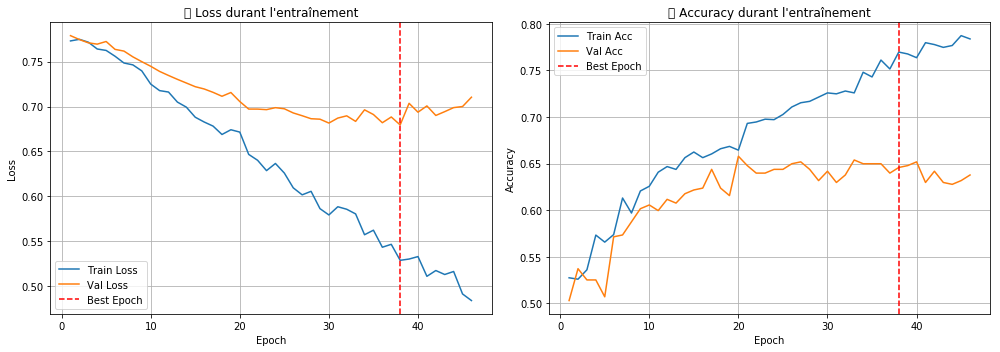

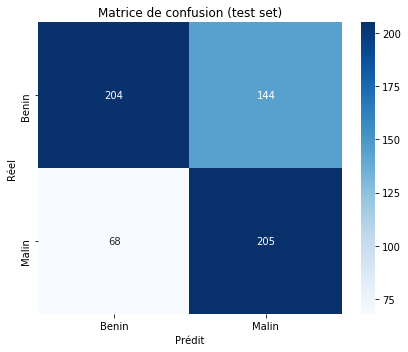

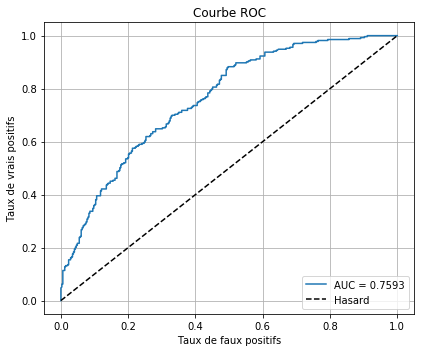


✅ Résultats enregistrés dans : evals/eval_effnet_b0_20250518_135234


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import torch
import os
from datetime import datetime

# 🕒 Timestamp pour le dossier
timestamp_eval = datetime.now().strftime("%Y%m%d_%H%M%S")

# 📂 Créer dossier d'évaluation unique
eval_dir = os.path.join("evals", f"eval_effnet_b0_{timestamp_eval}")
os.makedirs(eval_dir, exist_ok=True)

# 📈 Historique
epochs = range(1, len(train_losses) + 1)
opt_epoch = val_losses.index(min(val_losses)) + 1
end_val_loss = val_losses[-1]
end_val_acc = val_accs[-1]
opt_val_loss = val_losses[opt_epoch - 1]
opt_val_acc = val_accs[opt_epoch - 1]

# 🧠 Chargement du meilleur modèle
model_best = EfficientNetBinary().to(device)
best_model_path = "runs_dropout/effnet_b0_d30_run_20250518_132922/model/best_model.pth"
model_best.load_state_dict(torch.load(best_model_path))
model_best.eval()

# 📊 Prédictions sur test set
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1, 1).float()
        outputs = model_best(inputs)
        probas = torch.sigmoid(outputs)
        preds = (probas > 0.5).float()
        y_true.extend(labels.cpu().numpy().flatten())
        y_pred.extend(preds.cpu().numpy().flatten())
        y_scores.extend(probas.cpu().numpy().flatten())

# 📄 Rapport classification
classif_report = classification_report(y_true, y_pred, digits=4)
conf_matrix = confusion_matrix(y_true, y_pred)

# 💾 Sauvegarde texte résumé
with open(os.path.join(eval_dir, "resume.txt"), "w") as f:
    f.write("🎯 Résumé du modèle EfficientNetBinary\n")
    f.write(f"Nombre d'epochs : {len(epochs)}\n")
    f.write(f"Best epoch : {opt_epoch}\n")
    f.write(f"Val Acc finale : {end_val_acc:.4f} | optimale : {opt_val_acc:.4f}\n")
    f.write(f"Val Loss finale : {end_val_loss:.4f} | optimale : {opt_val_loss:.4f}\n\n")
    f.write("📄 Classification Report :\n")
    f.write(classif_report + "\n")
    f.write("📊 Matrice de confusion :\n")
    f.write(np.array2string(conf_matrix))

print("\n📄 Rapport de classification :")
print(classif_report)
print("\n📊 Matrice de confusion :")
print(conf_matrix)

# 🎨 Courbes entraînement
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.axvline(opt_epoch, color='r', linestyle='--', label='Best Epoch')
plt.title("📉 Loss durant l'entraînement")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.axvline(opt_epoch, color='r', linestyle='--', label='Best Epoch')
plt.title("📈 Accuracy durant l'entraînement")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(eval_dir, "courbes_entraînement.png"))
plt.show()

# 🔲 Matrice de confusion heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benin", "Malin"], yticklabels=["Benin", "Malin"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (test set)")
plt.tight_layout()
plt.savefig(os.path.join(eval_dir, "matrice_confusion.png"))
plt.show()

# 🔵 ROC & AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Hasard")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(eval_dir, "roc_curve.png"))
plt.show()

print(f"\n✅ Résultats enregistrés dans : {eval_dir}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

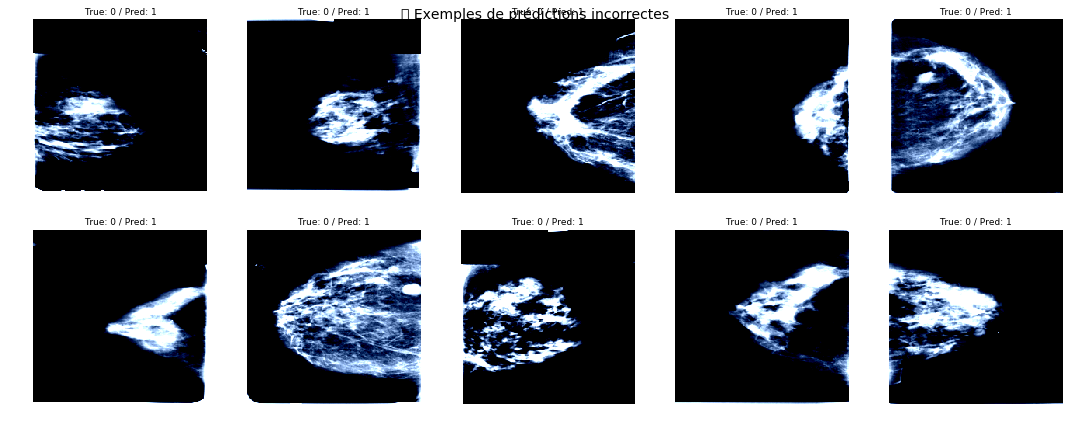

📥 10 images enregistrées dans le dossier `erreurs_model/`.


In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# === 1. Créer le dossier de sauvegarde ===
os.makedirs("erreurs_model", exist_ok=True)

# === 2. Récupérer les images mal classées ===
model.eval()
wrong_samples = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs)).squeeze()

        for i in range(len(images)):
            if preds[i].item() != labels[i].item():
                wrong_samples.append((images[i].cpu(), labels[i].item(), preds[i].item()))
                if len(wrong_samples) == 10:  # <-- nombre d'images à récupérer
                    break
        if len(wrong_samples) == 10:
            break

# === 3. Afficher et sauvegarder ===
plt.figure(figsize=(15, 6))
for idx, (img, true_label, pred_label) in enumerate(wrong_samples):
    img_np = img.numpy()
    if img_np.shape[0] == 1:
        img_np = img_np.squeeze(0)
        plt.subplot(2, 5, idx + 1)
        plt.imshow(img_np, cmap='gray')
    elif img_np.shape[0] == 3:
        img_np = np.transpose(img_np, (1, 2, 0))
        plt.subplot(2, 5, idx + 1)
        plt.imshow(img_np)
    else:
        raise ValueError(f"Format image inattendu : {img_np.shape}")

    plt.title(f"True: {int(true_label)} / Pred: {int(pred_label)}", fontsize=9)
    plt.axis("off")

    # Sauvegarde image seule
    plt.imsave(f"erreurs_model/wrong_{idx+1}.png", img_np, cmap='gray' if img_np.ndim == 2 else None)

plt.suptitle("❌ Exemples de prédictions incorrectes", fontsize=14)
plt.tight_layout()
plt.show()

print("📥 10 images enregistrées dans le dossier `erreurs_model/`.")


# DenseNet121

In [11]:
import torch
print(torch.cuda.get_device_name(0))


NVIDIA GeForce GTX TITAN X


In [21]:
import torch
import torch.nn as nn
from torchvision import models

class DenseNet121Binary(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.5, fine_tune=False):
        super().__init__()
        self.model = models.densenet121(pretrained=pretrained)

        # 🔁 Geler les couches sauf le classifier si fine_tune=False
        if not fine_tune:
            for param in self.model.features.parameters():
                param.requires_grad = False

        num_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_features, 1)
        )

    def forward(self, x):
        return self.model(x)



In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
from tqdm import tqdm
import os
import json

# === Paramètres ===
dropout_rate = 0.5
model_densenet = DenseNet121Binary(dropout_rate=dropout_rate)

# Geler toutes les couches du backbone
for param in model_densenet.model.features.parameters():
    param.requires_grad = False

# Garder uniquement la tête active pour l'entraînement initial
for param in model_densenet.model.classifier.parameters():
    param.requires_grad = True

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet = model_densenet.to(device)

# === Critère de perte avec pondération ===
n_pos = (train_labels == 1).sum()
n_neg = (train_labels == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# === Optimiseur pour les paramètres dégelés ===
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_densenet.parameters()), lr=1e-4)

# === Scheduler ===
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# === Sauvegarde des résultats ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(
    "runs_densenet_dropout", 
    f"densenet121_dropout{int(dropout_rate*100)}_bs4_finetune_run_{timestamp}"
)

model_dir = os.path.join(run_dir, "model")
log_dir = os.path.join(run_dir, "logs")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

best_model_path = os.path.join(model_dir, "best_model.pth")
final_model_path = os.path.join(model_dir, "final_model.pth")

train_losses, val_losses = [], []
train_accs, val_accs = [], []

num_epochs = 50
best_val_loss = float('inf')
patience = 8
patience_counter = 0

for epoch in range(num_epochs):
    if epoch == 5:
        print("\n🔓 Fine-tuning activé : dégel de toutes les couches DenseNet")
        for param in model_densenet.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model_densenet.parameters(), lr=1e-5)

    model_densenet.train()
    running_loss, correct, total = 0.0, 0, 0

    print(f"\n🟢 Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="🔄 Entraînement", leave=True):
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1, 1).float()

        optimizer.zero_grad()
        outputs = model_densenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # === Validation ===
    model_densenet.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="📊 Validation", leave=True):
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1, 1).float()
            outputs = model_densenet(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"📈 Epoch {epoch+1} Résumé : Train Loss = {epoch_loss:.4f}, Acc = {epoch_acc:.4f} | Val Loss = {val_loss:.4f}, Acc = {val_acc:.4f} | LR = {current_lr:.6f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model_densenet.state_dict(), best_model_path)
        print(f"✅ Nouveau meilleur modèle sauvegardé : {best_model_path}")
    else:
        patience_counter += 1
        print(f"⏳ Patience : {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping déclenché.")
            break

# === Sauvegarde finale
torch.save(model_densenet.state_dict(), final_model_path)
print(f"📦 Modèle final sauvegardé : {final_model_path}")

# === Logs
with open(os.path.join(log_dir, "losses.json"), "w") as f:
    json.dump({"train": train_losses, "val": val_losses}, f)
with open(os.path.join(log_dir, "metrics.json"), "w") as f:
    json.dump({"train": train_accs, "val": val_accs}, f)

print(f"📁 Historique sauvegardé dans : {log_dir}")


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]


🟢 Epoch 1/50


📊 Validation: 100%|██████████| 125/125 [00:09<00:00, 15.30it/s]


📈 Epoch 1 Résumé : Train Loss = 0.7921, Acc = 0.5083 | Val Loss = 0.7733, Acc = 0.5815 | LR = 0.000100


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

✅ Nouveau meilleur modèle sauvegardé : runs_densenet_dropout/densenet121_dropout50_bs4_finetune_run_20250518_113520/model/best_model.pth

🟢 Epoch 2/50


📊 Validation: 100%|██████████| 125/125 [00:09<00:00, 15.16it/s]


📈 Epoch 2 Résumé : Train Loss = 0.7859, Acc = 0.5280 | Val Loss = 0.7652, Acc = 0.5976 | LR = 0.000100


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

✅ Nouveau meilleur modèle sauvegardé : runs_densenet_dropout/densenet121_dropout50_bs4_finetune_run_20250518_113520/model/best_model.pth

🟢 Epoch 3/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 3 Résumé : Train Loss = 0.7860, Acc = 0.5254 | Val Loss = 0.7743, Acc = 0.5734 | LR = 0.000100
⏳ Patience : 1/8

🟢 Epoch 4/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 4 Résumé : Train Loss = 0.7848, Acc = 0.5219 | Val Loss = 0.7688, Acc = 0.5734 | LR = 0.000100
⏳ Patience : 2/8

🟢 Epoch 5/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 5 Résumé : Train Loss = 0.7767, Acc = 0.5335 | Val Loss = 0.7680, Acc = 0.5815 | LR = 0.000100
⏳ Patience : 3/8

🔓 Fine-tuning activé : dégel de toutes les couches DenseNet

🟢 Epoch 6/50


📊 Validation: 100%|██████████| 125/125 [00:09<00:00, 14.38it/s]


📈 Epoch 6 Résumé : Train Loss = 0.7513, Acc = 0.5889 | Val Loss = 0.7052, Acc = 0.6559 | LR = 0.000010


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

✅ Nouveau meilleur modèle sauvegardé : runs_densenet_dropout/densenet121_dropout50_bs4_finetune_run_20250518_113520/model/best_model.pth

🟢 Epoch 7/50


📊 Validation: 100%|██████████| 125/125 [00:09<00:00, 14.49it/s]


📈 Epoch 7 Résumé : Train Loss = 0.7227, Acc = 0.6282 | Val Loss = 0.6661, Acc = 0.6700 | LR = 0.000010


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

✅ Nouveau meilleur modèle sauvegardé : runs_densenet_dropout/densenet121_dropout50_bs4_finetune_run_20250518_113520/model/best_model.pth

🟢 Epoch 8/50


📊 Validation: 100%|██████████| 125/125 [00:09<00:00, 14.38it/s]


📈 Epoch 8 Résumé : Train Loss = 0.6838, Acc = 0.6549 | Val Loss = 0.6594, Acc = 0.6841 | LR = 0.000010


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

✅ Nouveau meilleur modèle sauvegardé : runs_densenet_dropout/densenet121_dropout50_bs4_finetune_run_20250518_113520/model/best_model.pth

🟢 Epoch 9/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 9 Résumé : Train Loss = 0.6521, Acc = 0.6856 | Val Loss = 0.6519, Acc = 0.6962 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_densenet_dropout/densenet121_dropout50_bs4_finetune_run_20250518_113520/model/best_model.pth

🟢 Epoch 10/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 10 Résumé : Train Loss = 0.6081, Acc = 0.7305 | Val Loss = 0.6134, Acc = 0.7103 | LR = 0.000010
✅ Nouveau meilleur modèle sauvegardé : runs_densenet_dropout/densenet121_dropout50_bs4_finetune_run_20250518_113520/model/best_model.pth

🟢 Epoch 11/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 11 Résumé : Train Loss = 0.5591, Acc = 0.7652 | Val Loss = 0.6415, Acc = 0.6942 | LR = 0.000010
⏳ Patience : 1/8

🟢 Epoch 12/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 12 Résumé : Train Loss = 0.5066, Acc = 0.7940 | Val Loss = 0.6423, Acc = 0.7103 | LR = 0.000010
⏳ Patience : 2/8

🟢 Epoch 13/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 13 Résumé : Train Loss = 0.4319, Acc = 0.8317 | Val Loss = 0.6585, Acc = 0.7163 | LR = 0.000010
⏳ Patience : 3/8

🟢 Epoch 14/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 14 Résumé : Train Loss = 0.3950, Acc = 0.8549 | Val Loss = 0.6472, Acc = 0.7082 | LR = 0.000010
Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.
⏳ Patience : 4/8

🟢 Epoch 15/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 15 Résumé : Train Loss = 0.3251, Acc = 0.9013 | Val Loss = 0.7362, Acc = 0.7022 | LR = 0.000010
⏳ Patience : 5/8

🟢 Epoch 16/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 16 Résumé : Train Loss = 0.3022, Acc = 0.9018 | Val Loss = 0.6783, Acc = 0.7183 | LR = 0.000010
⏳ Patience : 6/8

🟢 Epoch 17/50


🔄 Entraînement:   0%|          | 0/497 [00:00<?, ?it/s]

📈 Epoch 17 Résumé : Train Loss = 0.2661, Acc = 0.9058 | Val Loss = 0.7506, Acc = 0.6982 | LR = 0.000010
⏳ Patience : 7/8

🟢 Epoch 18/50


📊 Validation: 100%|██████████| 125/125 [00:09<00:00, 14.49it/s]


📈 Epoch 18 Résumé : Train Loss = 0.2577, Acc = 0.9194 | Val Loss = 0.7107, Acc = 0.6922 | LR = 0.000010
Epoch 00018: reducing learning rate of group 0 to 2.5000e-05.
⏳ Patience : 8/8
🛑 Early stopping déclenché.
📦 Modèle final sauvegardé : runs_densenet_dropout/densenet121_dropout50_bs4_finetune_run_20250518_113520/model/final_model.pth
📁 Historique sauvegardé dans : runs_densenet_dropout/densenet121_dropout50_bs4_finetune_run_20250518_113520/logs



🎯 Résumé du modèle :
Modèle : DenseNet121Binary (Dropout 0.5)
Run : densenet121_dropout50_bs4_finetune_run_20250518_113520
Meilleure epoch : 10
Val Acc finale : 0.6922 | optimale : 0.7103
Val Loss finale : 0.7107 | optimale : 0.6134

📄 Classification report :
               precision    recall  f1-score   support

         0.0     0.7532    0.6667    0.7073       348
         1.0     0.6294    0.7216    0.6724       273

   micro avg     0.6908    0.6908    0.6908       621
   macro avg     0.6913    0.6941    0.6898       621
weighted avg     0.6988    0.6908    0.6919       621


📊 Matrice de confusion :
 [[232 116]
 [ 76 197]]


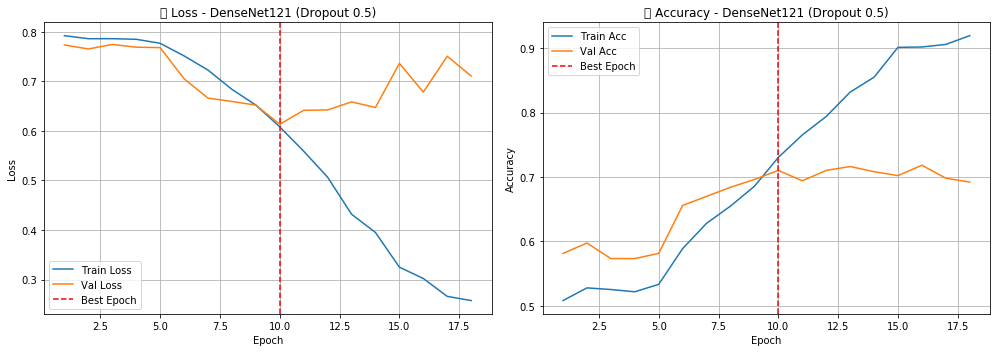

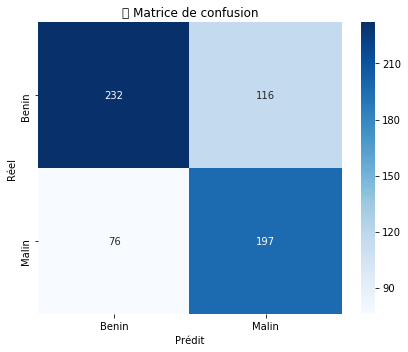

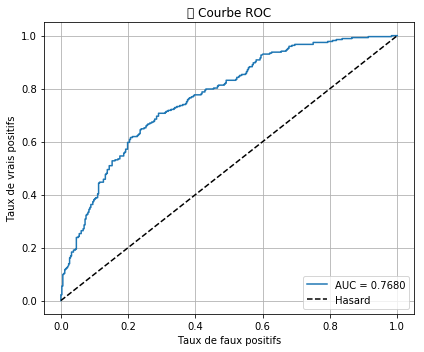


✅ Tous les résultats ont été enregistrés dans : evals_densenet_dropout/eval_densenet121_dropout50_bs4_finetune_run_20250518_113520_20250518_121634


In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import torch
import os  # ✅ Corrigé ici (remplace `import o`)
from datetime import datetime

# === Paramètres ===
dropout_rate = 0.5
run_name = "densenet121_dropout50_bs4_finetune_run_20250518_113520"

model_path = os.path.join("runs_densenet_dropout", run_name, "model", "best_model.pth")

# === 📂 Création du dossier horodaté pour les résultats ===
timestamp_eval = datetime.now().strftime("%Y%m%d_%H%M%S")
eval_dir = os.path.join("evals_densenet_dropout", f"eval_{run_name}_{timestamp_eval}")
os.makedirs(eval_dir, exist_ok=True)

# === 📈 Historique depuis l'entraînement (doit exister dans le contexte)
epochs = range(1, len(train_losses) + 1)
opt_epoch = val_losses.index(min(val_losses)) + 1
end_val_loss = val_losses[-1]
end_val_acc = val_accs[-1]
opt_val_loss = val_losses[opt_epoch - 1]
opt_val_acc = val_accs[opt_epoch - 1]

# === 🔥 Chargement du modèle
model_best = DenseNet121Binary(dropout_rate=dropout_rate).to(device)
model_best.load_state_dict(torch.load(model_path))
model_best.eval()

# === 📊 Prédictions sur test set
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1, 1).float()
        outputs = model_best(inputs)
        probas = torch.sigmoid(outputs)
        preds = (probas > 0.5).float()

        y_true.extend(labels.cpu().numpy().flatten())
        y_pred.extend(preds.cpu().numpy().flatten())
        y_scores.extend(probas.cpu().numpy().flatten())

# === 📝 Classification
classif_report = classification_report(y_true, y_pred, digits=4)
conf_matrix = confusion_matrix(y_true, y_pred)

# === Résumé console
print("\n🎯 Résumé du modèle :")
print(f"Modèle : DenseNet121Binary (Dropout {dropout_rate})")
print(f"Run : {run_name}")
print(f"Meilleure epoch : {opt_epoch}")
print(f"Val Acc finale : {end_val_acc:.4f} | optimale : {opt_val_acc:.4f}")
print(f"Val Loss finale : {end_val_loss:.4f} | optimale : {opt_val_loss:.4f}")
print("\n📄 Classification report :\n", classif_report)
print("\n📊 Matrice de confusion :\n", conf_matrix)

# === 💾 Sauvegarde du résumé texte
with open(os.path.join(eval_dir, "resume.txt"), "w") as f:
    f.write(f"🎯 DenseNet121Binary (dropout={dropout_rate})\n")
    f.write(f"Run name : {run_name}\n")
    f.write(f"Best epoch : {opt_epoch}\n")
    f.write(f"Val Acc finale : {end_val_acc:.4f} | optimale : {opt_val_acc:.4f}\n")
    f.write(f"Val Loss finale : {end_val_loss:.4f} | optimale : {opt_val_loss:.4f}\n\n")
    f.write("📄 Rapport de classification :\n" + classif_report + "\n")
    f.write("📊 Matrice de confusion :\n" + np.array2string(conf_matrix))

# === 📉📈 Courbes Loss & Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.axvline(opt_epoch, color='r', linestyle='--', label='Best Epoch')
plt.title(f"📉 Loss - DenseNet121 (Dropout {dropout_rate})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.axvline(opt_epoch, color='r', linestyle='--', label='Best Epoch')
plt.title(f"📈 Accuracy - DenseNet121 (Dropout {dropout_rate})")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(eval_dir, "courbes_entraînement.png"))
plt.show()

# === 🔲 Matrice de confusion (heatmap)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benin", "Malin"], yticklabels=["Benin", "Malin"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("🔲 Matrice de confusion")
plt.tight_layout()
plt.savefig(os.path.join(eval_dir, "matrice_confusion.png"))
plt.show()

# === 🔵 Courbe ROC & AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Hasard")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("📈 Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(eval_dir, "roc_curve.png"))
plt.show()

print(f"\n✅ Tous les résultats ont été enregistrés dans : {eval_dir}")


In [19]:
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM

# ✅ Charger les images depuis .npy
images = np.load("FULL/train_tensor.npy")
labels = np.load("FULL/train_labels.npy")

# 🔢 Choisir l’image
index = 0
image = images[index]
if image.shape[-1] == 1:
    image = image.squeeze(-1)
img_pil = Image.fromarray((image * 255).astype(np.uint8))

# 📦 Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
input_tensor = transform(img_pil).unsqueeze(0)  # [1, 1, 224, 224]
input_tensor.requires_grad = True

# 🎯 Charger le modèle
model_cam = DenseNet121Binary()
model_cam.load_state_dict(torch.load("model_densenet121_best.pth", map_location="cpu"))
model_cam.eval()

# 🔍 GradCAM
cam_extractor = GradCAM(model_cam, target_layer="model.features.denseblock4.denselayer16.conv2")

# 🚀 Prédiction
output = model_cam(input_tensor)
class_idx = int((torch.sigmoid(output) > 0.5).item())

# 🗺️ Extraire la carte
activation_map = cam_extractor(class_idx, output)

# 🎨 Affichage côte à côte
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_pil, cmap='gray')
plt.title("🖼️ Image originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_pil, cmap='gray')
plt.imshow(activation_map[0].squeeze(), cmap='jet', alpha=0.5)
plt.title(f"🔥 Grad-CAM - Prédite: {class_idx} | Réelle: {labels[index]}")
plt.axis("off")

plt.tight_layout()
plt.show()


Loaded pretrained weights for efficientnet-b0


RuntimeError: Error(s) in loading state_dict for EfficientNetBinary:
	Missing key(s) in state_dict: "base._conv_stem.weight", "base._bn0.weight", "base._bn0.bias", "base._bn0.running_mean", "base._bn0.running_var", "base._blocks.0._depthwise_conv.weight", "base._blocks.0._bn1.weight", "base._blocks.0._bn1.bias", "base._blocks.0._bn1.running_mean", "base._blocks.0._bn1.running_var", "base._blocks.0._se_reduce.weight", "base._blocks.0._se_reduce.bias", "base._blocks.0._se_expand.weight", "base._blocks.0._se_expand.bias", "base._blocks.0._project_conv.weight", "base._blocks.0._bn2.weight", "base._blocks.0._bn2.bias", "base._blocks.0._bn2.running_mean", "base._blocks.0._bn2.running_var", "base._blocks.1._expand_conv.weight", "base._blocks.1._bn0.weight", "base._blocks.1._bn0.bias", "base._blocks.1._bn0.running_mean", "base._blocks.1._bn0.running_var", "base._blocks.1._depthwise_conv.weight", "base._blocks.1._bn1.weight", "base._blocks.1._bn1.bias", "base._blocks.1._bn1.running_mean", "base._blocks.1._bn1.running_var", "base._blocks.1._se_reduce.weight", "base._blocks.1._se_reduce.bias", "base._blocks.1._se_expand.weight", "base._blocks.1._se_expand.bias", "base._blocks.1._project_conv.weight", "base._blocks.1._bn2.weight", "base._blocks.1._bn2.bias", "base._blocks.1._bn2.running_mean", "base._blocks.1._bn2.running_var", "base._blocks.2._expand_conv.weight", "base._blocks.2._bn0.weight", "base._blocks.2._bn0.bias", "base._blocks.2._bn0.running_mean", "base._blocks.2._bn0.running_var", "base._blocks.2._depthwise_conv.weight", "base._blocks.2._bn1.weight", "base._blocks.2._bn1.bias", "base._blocks.2._bn1.running_mean", "base._blocks.2._bn1.running_var", "base._blocks.2._se_reduce.weight", "base._blocks.2._se_reduce.bias", "base._blocks.2._se_expand.weight", "base._blocks.2._se_expand.bias", "base._blocks.2._project_conv.weight", "base._blocks.2._bn2.weight", "base._blocks.2._bn2.bias", "base._blocks.2._bn2.running_mean", "base._blocks.2._bn2.running_var", "base._blocks.3._expand_conv.weight", "base._blocks.3._bn0.weight", "base._blocks.3._bn0.bias", "base._blocks.3._bn0.running_mean", "base._blocks.3._bn0.running_var", "base._blocks.3._depthwise_conv.weight", "base._blocks.3._bn1.weight", "base._blocks.3._bn1.bias", "base._blocks.3._bn1.running_mean", "base._blocks.3._bn1.running_var", "base._blocks.3._se_reduce.weight", "base._blocks.3._se_reduce.bias", "base._blocks.3._se_expand.weight", "base._blocks.3._se_expand.bias", "base._blocks.3._project_conv.weight", "base._blocks.3._bn2.weight", "base._blocks.3._bn2.bias", "base._blocks.3._bn2.running_mean", "base._blocks.3._bn2.running_var", "base._blocks.4._expand_conv.weight", "base._blocks.4._bn0.weight", "base._blocks.4._bn0.bias", "base._blocks.4._bn0.running_mean", "base._blocks.4._bn0.running_var", "base._blocks.4._depthwise_conv.weight", "base._blocks.4._bn1.weight", "base._blocks.4._bn1.bias", "base._blocks.4._bn1.running_mean", "base._blocks.4._bn1.running_var", "base._blocks.4._se_reduce.weight", "base._blocks.4._se_reduce.bias", "base._blocks.4._se_expand.weight", "base._blocks.4._se_expand.bias", "base._blocks.4._project_conv.weight", "base._blocks.4._bn2.weight", "base._blocks.4._bn2.bias", "base._blocks.4._bn2.running_mean", "base._blocks.4._bn2.running_var", "base._blocks.5._expand_conv.weight", "base._blocks.5._bn0.weight", "base._blocks.5._bn0.bias", "base._blocks.5._bn0.running_mean", "base._blocks.5._bn0.running_var", "base._blocks.5._depthwise_conv.weight", "base._blocks.5._bn1.weight", "base._blocks.5._bn1.bias", "base._blocks.5._bn1.running_mean", "base._blocks.5._bn1.running_var", "base._blocks.5._se_reduce.weight", "base._blocks.5._se_reduce.bias", "base._blocks.5._se_expand.weight", "base._blocks.5._se_expand.bias", "base._blocks.5._project_conv.weight", "base._blocks.5._bn2.weight", "base._blocks.5._bn2.bias", "base._blocks.5._bn2.running_mean", "base._blocks.5._bn2.running_var", "base._blocks.6._expand_conv.weight", "base._blocks.6._bn0.weight", "base._blocks.6._bn0.bias", "base._blocks.6._bn0.running_mean", "base._blocks.6._bn0.running_var", "base._blocks.6._depthwise_conv.weight", "base._blocks.6._bn1.weight", "base._blocks.6._bn1.bias", "base._blocks.6._bn1.running_mean", "base._blocks.6._bn1.running_var", "base._blocks.6._se_reduce.weight", "base._blocks.6._se_reduce.bias", "base._blocks.6._se_expand.weight", "base._blocks.6._se_expand.bias", "base._blocks.6._project_conv.weight", "base._blocks.6._bn2.weight", "base._blocks.6._bn2.bias", "base._blocks.6._bn2.running_mean", "base._blocks.6._bn2.running_var", "base._blocks.7._expand_conv.weight", "base._blocks.7._bn0.weight", "base._blocks.7._bn0.bias", "base._blocks.7._bn0.running_mean", "base._blocks.7._bn0.running_var", "base._blocks.7._depthwise_conv.weight", "base._blocks.7._bn1.weight", "base._blocks.7._bn1.bias", "base._blocks.7._bn1.running_mean", "base._blocks.7._bn1.running_var", "base._blocks.7._se_reduce.weight", "base._blocks.7._se_reduce.bias", "base._blocks.7._se_expand.weight", "base._blocks.7._se_expand.bias", "base._blocks.7._project_conv.weight", "base._blocks.7._bn2.weight", "base._blocks.7._bn2.bias", "base._blocks.7._bn2.running_mean", "base._blocks.7._bn2.running_var", "base._blocks.8._expand_conv.weight", "base._blocks.8._bn0.weight", "base._blocks.8._bn0.bias", "base._blocks.8._bn0.running_mean", "base._blocks.8._bn0.running_var", "base._blocks.8._depthwise_conv.weight", "base._blocks.8._bn1.weight", "base._blocks.8._bn1.bias", "base._blocks.8._bn1.running_mean", "base._blocks.8._bn1.running_var", "base._blocks.8._se_reduce.weight", "base._blocks.8._se_reduce.bias", "base._blocks.8._se_expand.weight", "base._blocks.8._se_expand.bias", "base._blocks.8._project_conv.weight", "base._blocks.8._bn2.weight", "base._blocks.8._bn2.bias", "base._blocks.8._bn2.running_mean", "base._blocks.8._bn2.running_var", "base._blocks.9._expand_conv.weight", "base._blocks.9._bn0.weight", "base._blocks.9._bn0.bias", "base._blocks.9._bn0.running_mean", "base._blocks.9._bn0.running_var", "base._blocks.9._depthwise_conv.weight", "base._blocks.9._bn1.weight", "base._blocks.9._bn1.bias", "base._blocks.9._bn1.running_mean", "base._blocks.9._bn1.running_var", "base._blocks.9._se_reduce.weight", "base._blocks.9._se_reduce.bias", "base._blocks.9._se_expand.weight", "base._blocks.9._se_expand.bias", "base._blocks.9._project_conv.weight", "base._blocks.9._bn2.weight", "base._blocks.9._bn2.bias", "base._blocks.9._bn2.running_mean", "base._blocks.9._bn2.running_var", "base._blocks.10._expand_conv.weight", "base._blocks.10._bn0.weight", "base._blocks.10._bn0.bias", "base._blocks.10._bn0.running_mean", "base._blocks.10._bn0.running_var", "base._blocks.10._depthwise_conv.weight", "base._blocks.10._bn1.weight", "base._blocks.10._bn1.bias", "base._blocks.10._bn1.running_mean", "base._blocks.10._bn1.running_var", "base._blocks.10._se_reduce.weight", "base._blocks.10._se_reduce.bias", "base._blocks.10._se_expand.weight", "base._blocks.10._se_expand.bias", "base._blocks.10._project_conv.weight", "base._blocks.10._bn2.weight", "base._blocks.10._bn2.bias", "base._blocks.10._bn2.running_mean", "base._blocks.10._bn2.running_var", "base._blocks.11._expand_conv.weight", "base._blocks.11._bn0.weight", "base._blocks.11._bn0.bias", "base._blocks.11._bn0.running_mean", "base._blocks.11._bn0.running_var", "base._blocks.11._depthwise_conv.weight", "base._blocks.11._bn1.weight", "base._blocks.11._bn1.bias", "base._blocks.11._bn1.running_mean", "base._blocks.11._bn1.running_var", "base._blocks.11._se_reduce.weight", "base._blocks.11._se_reduce.bias", "base._blocks.11._se_expand.weight", "base._blocks.11._se_expand.bias", "base._blocks.11._project_conv.weight", "base._blocks.11._bn2.weight", "base._blocks.11._bn2.bias", "base._blocks.11._bn2.running_mean", "base._blocks.11._bn2.running_var", "base._blocks.12._expand_conv.weight", "base._blocks.12._bn0.weight", "base._blocks.12._bn0.bias", "base._blocks.12._bn0.running_mean", "base._blocks.12._bn0.running_var", "base._blocks.12._depthwise_conv.weight", "base._blocks.12._bn1.weight", "base._blocks.12._bn1.bias", "base._blocks.12._bn1.running_mean", "base._blocks.12._bn1.running_var", "base._blocks.12._se_reduce.weight", "base._blocks.12._se_reduce.bias", "base._blocks.12._se_expand.weight", "base._blocks.12._se_expand.bias", "base._blocks.12._project_conv.weight", "base._blocks.12._bn2.weight", "base._blocks.12._bn2.bias", "base._blocks.12._bn2.running_mean", "base._blocks.12._bn2.running_var", "base._blocks.13._expand_conv.weight", "base._blocks.13._bn0.weight", "base._blocks.13._bn0.bias", "base._blocks.13._bn0.running_mean", "base._blocks.13._bn0.running_var", "base._blocks.13._depthwise_conv.weight", "base._blocks.13._bn1.weight", "base._blocks.13._bn1.bias", "base._blocks.13._bn1.running_mean", "base._blocks.13._bn1.running_var", "base._blocks.13._se_reduce.weight", "base._blocks.13._se_reduce.bias", "base._blocks.13._se_expand.weight", "base._blocks.13._se_expand.bias", "base._blocks.13._project_conv.weight", "base._blocks.13._bn2.weight", "base._blocks.13._bn2.bias", "base._blocks.13._bn2.running_mean", "base._blocks.13._bn2.running_var", "base._blocks.14._expand_conv.weight", "base._blocks.14._bn0.weight", "base._blocks.14._bn0.bias", "base._blocks.14._bn0.running_mean", "base._blocks.14._bn0.running_var", "base._blocks.14._depthwise_conv.weight", "base._blocks.14._bn1.weight", "base._blocks.14._bn1.bias", "base._blocks.14._bn1.running_mean", "base._blocks.14._bn1.running_var", "base._blocks.14._se_reduce.weight", "base._blocks.14._se_reduce.bias", "base._blocks.14._se_expand.weight", "base._blocks.14._se_expand.bias", "base._blocks.14._project_conv.weight", "base._blocks.14._bn2.weight", "base._blocks.14._bn2.bias", "base._blocks.14._bn2.running_mean", "base._blocks.14._bn2.running_var", "base._blocks.15._expand_conv.weight", "base._blocks.15._bn0.weight", "base._blocks.15._bn0.bias", "base._blocks.15._bn0.running_mean", "base._blocks.15._bn0.running_var", "base._blocks.15._depthwise_conv.weight", "base._blocks.15._bn1.weight", "base._blocks.15._bn1.bias", "base._blocks.15._bn1.running_mean", "base._blocks.15._bn1.running_var", "base._blocks.15._se_reduce.weight", "base._blocks.15._se_reduce.bias", "base._blocks.15._se_expand.weight", "base._blocks.15._se_expand.bias", "base._blocks.15._project_conv.weight", "base._blocks.15._bn2.weight", "base._blocks.15._bn2.bias", "base._blocks.15._bn2.running_mean", "base._blocks.15._bn2.running_var", "base._conv_head.weight", "base._bn1.weight", "base._bn1.bias", "base._bn1.running_mean", "base._bn1.running_var", "base._fc.weight", "base._fc.bias". 
	Unexpected key(s) in state_dict: "model.features.conv0.weight", "model.features.norm0.weight", "model.features.norm0.bias", "model.features.norm0.running_mean", "model.features.norm0.running_var", "model.features.norm0.num_batches_tracked", "model.features.denseblock1.denselayer1.norm1.weight", "model.features.denseblock1.denselayer1.norm1.bias", "model.features.denseblock1.denselayer1.norm1.running_mean", "model.features.denseblock1.denselayer1.norm1.running_var", "model.features.denseblock1.denselayer1.norm1.num_batches_tracked", "model.features.denseblock1.denselayer1.conv1.weight", "model.features.denseblock1.denselayer1.norm2.weight", "model.features.denseblock1.denselayer1.norm2.bias", "model.features.denseblock1.denselayer1.norm2.running_mean", "model.features.denseblock1.denselayer1.norm2.running_var", "model.features.denseblock1.denselayer1.norm2.num_batches_tracked", "model.features.denseblock1.denselayer1.conv2.weight", "model.features.denseblock1.denselayer2.norm1.weight", "model.features.denseblock1.denselayer2.norm1.bias", "model.features.denseblock1.denselayer2.norm1.running_mean", "model.features.denseblock1.denselayer2.norm1.running_var", "model.features.denseblock1.denselayer2.norm1.num_batches_tracked", "model.features.denseblock1.denselayer2.conv1.weight", "model.features.denseblock1.denselayer2.norm2.weight", "model.features.denseblock1.denselayer2.norm2.bias", "model.features.denseblock1.denselayer2.norm2.running_mean", "model.features.denseblock1.denselayer2.norm2.running_var", "model.features.denseblock1.denselayer2.norm2.num_batches_tracked", "model.features.denseblock1.denselayer2.conv2.weight", "model.features.denseblock1.denselayer3.norm1.weight", "model.features.denseblock1.denselayer3.norm1.bias", "model.features.denseblock1.denselayer3.norm1.running_mean", "model.features.denseblock1.denselayer3.norm1.running_var", "model.features.denseblock1.denselayer3.norm1.num_batches_tracked", "model.features.denseblock1.denselayer3.conv1.weight", "model.features.denseblock1.denselayer3.norm2.weight", "model.features.denseblock1.denselayer3.norm2.bias", "model.features.denseblock1.denselayer3.norm2.running_mean", "model.features.denseblock1.denselayer3.norm2.running_var", "model.features.denseblock1.denselayer3.norm2.num_batches_tracked", "model.features.denseblock1.denselayer3.conv2.weight", "model.features.denseblock1.denselayer4.norm1.weight", "model.features.denseblock1.denselayer4.norm1.bias", "model.features.denseblock1.denselayer4.norm1.running_mean", "model.features.denseblock1.denselayer4.norm1.running_var", "model.features.denseblock1.denselayer4.norm1.num_batches_tracked", "model.features.denseblock1.denselayer4.conv1.weight", "model.features.denseblock1.denselayer4.norm2.weight", "model.features.denseblock1.denselayer4.norm2.bias", "model.features.denseblock1.denselayer4.norm2.running_mean", "model.features.denseblock1.denselayer4.norm2.running_var", "model.features.denseblock1.denselayer4.norm2.num_batches_tracked", "model.features.denseblock1.denselayer4.conv2.weight", "model.features.denseblock1.denselayer5.norm1.weight", "model.features.denseblock1.denselayer5.norm1.bias", "model.features.denseblock1.denselayer5.norm1.running_mean", "model.features.denseblock1.denselayer5.norm1.running_var", "model.features.denseblock1.denselayer5.norm1.num_batches_tracked", "model.features.denseblock1.denselayer5.conv1.weight", "model.features.denseblock1.denselayer5.norm2.weight", "model.features.denseblock1.denselayer5.norm2.bias", "model.features.denseblock1.denselayer5.norm2.running_mean", "model.features.denseblock1.denselayer5.norm2.running_var", "model.features.denseblock1.denselayer5.norm2.num_batches_tracked", "model.features.denseblock1.denselayer5.conv2.weight", "model.features.denseblock1.denselayer6.norm1.weight", "model.features.denseblock1.denselayer6.norm1.bias", "model.features.denseblock1.denselayer6.norm1.running_mean", "model.features.denseblock1.denselayer6.norm1.running_var", "model.features.denseblock1.denselayer6.norm1.num_batches_tracked", "model.features.denseblock1.denselayer6.conv1.weight", "model.features.denseblock1.denselayer6.norm2.weight", "model.features.denseblock1.denselayer6.norm2.bias", "model.features.denseblock1.denselayer6.norm2.running_mean", "model.features.denseblock1.denselayer6.norm2.running_var", "model.features.denseblock1.denselayer6.norm2.num_batches_tracked", "model.features.denseblock1.denselayer6.conv2.weight", "model.features.transition1.norm.weight", "model.features.transition1.norm.bias", "model.features.transition1.norm.running_mean", "model.features.transition1.norm.running_var", "model.features.transition1.norm.num_batches_tracked", "model.features.transition1.conv.weight", "model.features.denseblock2.denselayer1.norm1.weight", "model.features.denseblock2.denselayer1.norm1.bias", "model.features.denseblock2.denselayer1.norm1.running_mean", "model.features.denseblock2.denselayer1.norm1.running_var", "model.features.denseblock2.denselayer1.norm1.num_batches_tracked", "model.features.denseblock2.denselayer1.conv1.weight", "model.features.denseblock2.denselayer1.norm2.weight", "model.features.denseblock2.denselayer1.norm2.bias", "model.features.denseblock2.denselayer1.norm2.running_mean", "model.features.denseblock2.denselayer1.norm2.running_var", "model.features.denseblock2.denselayer1.norm2.num_batches_tracked", "model.features.denseblock2.denselayer1.conv2.weight", "model.features.denseblock2.denselayer2.norm1.weight", "model.features.denseblock2.denselayer2.norm1.bias", "model.features.denseblock2.denselayer2.norm1.running_mean", "model.features.denseblock2.denselayer2.norm1.running_var", "model.features.denseblock2.denselayer2.norm1.num_batches_tracked", "model.features.denseblock2.denselayer2.conv1.weight", "model.features.denseblock2.denselayer2.norm2.weight", "model.features.denseblock2.denselayer2.norm2.bias", "model.features.denseblock2.denselayer2.norm2.running_mean", "model.features.denseblock2.denselayer2.norm2.running_var", "model.features.denseblock2.denselayer2.norm2.num_batches_tracked", "model.features.denseblock2.denselayer2.conv2.weight", "model.features.denseblock2.denselayer3.norm1.weight", "model.features.denseblock2.denselayer3.norm1.bias", "model.features.denseblock2.denselayer3.norm1.running_mean", "model.features.denseblock2.denselayer3.norm1.running_var", "model.features.denseblock2.denselayer3.norm1.num_batches_tracked", "model.features.denseblock2.denselayer3.conv1.weight", "model.features.denseblock2.denselayer3.norm2.weight", "model.features.denseblock2.denselayer3.norm2.bias", "model.features.denseblock2.denselayer3.norm2.running_mean", "model.features.denseblock2.denselayer3.norm2.running_var", "model.features.denseblock2.denselayer3.norm2.num_batches_tracked", "model.features.denseblock2.denselayer3.conv2.weight", "model.features.denseblock2.denselayer4.norm1.weight", "model.features.denseblock2.denselayer4.norm1.bias", "model.features.denseblock2.denselayer4.norm1.running_mean", "model.features.denseblock2.denselayer4.norm1.running_var", "model.features.denseblock2.denselayer4.norm1.num_batches_tracked", "model.features.denseblock2.denselayer4.conv1.weight", "model.features.denseblock2.denselayer4.norm2.weight", "model.features.denseblock2.denselayer4.norm2.bias", "model.features.denseblock2.denselayer4.norm2.running_mean", "model.features.denseblock2.denselayer4.norm2.running_var", "model.features.denseblock2.denselayer4.norm2.num_batches_tracked", "model.features.denseblock2.denselayer4.conv2.weight", "model.features.denseblock2.denselayer5.norm1.weight", "model.features.denseblock2.denselayer5.norm1.bias", "model.features.denseblock2.denselayer5.norm1.running_mean", "model.features.denseblock2.denselayer5.norm1.running_var", "model.features.denseblock2.denselayer5.norm1.num_batches_tracked", "model.features.denseblock2.denselayer5.conv1.weight", "model.features.denseblock2.denselayer5.norm2.weight", "model.features.denseblock2.denselayer5.norm2.bias", "model.features.denseblock2.denselayer5.norm2.running_mean", "model.features.denseblock2.denselayer5.norm2.running_var", "model.features.denseblock2.denselayer5.norm2.num_batches_tracked", "model.features.denseblock2.denselayer5.conv2.weight", "model.features.denseblock2.denselayer6.norm1.weight", "model.features.denseblock2.denselayer6.norm1.bias", "model.features.denseblock2.denselayer6.norm1.running_mean", "model.features.denseblock2.denselayer6.norm1.running_var", "model.features.denseblock2.denselayer6.norm1.num_batches_tracked", "model.features.denseblock2.denselayer6.conv1.weight", "model.features.denseblock2.denselayer6.norm2.weight", "model.features.denseblock2.denselayer6.norm2.bias", "model.features.denseblock2.denselayer6.norm2.running_mean", "model.features.denseblock2.denselayer6.norm2.running_var", "model.features.denseblock2.denselayer6.norm2.num_batches_tracked", "model.features.denseblock2.denselayer6.conv2.weight", "model.features.denseblock2.denselayer7.norm1.weight", "model.features.denseblock2.denselayer7.norm1.bias", "model.features.denseblock2.denselayer7.norm1.running_mean", "model.features.denseblock2.denselayer7.norm1.running_var", "model.features.denseblock2.denselayer7.norm1.num_batches_tracked", "model.features.denseblock2.denselayer7.conv1.weight", "model.features.denseblock2.denselayer7.norm2.weight", "model.features.denseblock2.denselayer7.norm2.bias", "model.features.denseblock2.denselayer7.norm2.running_mean", "model.features.denseblock2.denselayer7.norm2.running_var", "model.features.denseblock2.denselayer7.norm2.num_batches_tracked", "model.features.denseblock2.denselayer7.conv2.weight", "model.features.denseblock2.denselayer8.norm1.weight", "model.features.denseblock2.denselayer8.norm1.bias", "model.features.denseblock2.denselayer8.norm1.running_mean", "model.features.denseblock2.denselayer8.norm1.running_var", "model.features.denseblock2.denselayer8.norm1.num_batches_tracked", "model.features.denseblock2.denselayer8.conv1.weight", "model.features.denseblock2.denselayer8.norm2.weight", "model.features.denseblock2.denselayer8.norm2.bias", "model.features.denseblock2.denselayer8.norm2.running_mean", "model.features.denseblock2.denselayer8.norm2.running_var", "model.features.denseblock2.denselayer8.norm2.num_batches_tracked", "model.features.denseblock2.denselayer8.conv2.weight", "model.features.denseblock2.denselayer9.norm1.weight", "model.features.denseblock2.denselayer9.norm1.bias", "model.features.denseblock2.denselayer9.norm1.running_mean", "model.features.denseblock2.denselayer9.norm1.running_var", "model.features.denseblock2.denselayer9.norm1.num_batches_tracked", "model.features.denseblock2.denselayer9.conv1.weight", "model.features.denseblock2.denselayer9.norm2.weight", "model.features.denseblock2.denselayer9.norm2.bias", "model.features.denseblock2.denselayer9.norm2.running_mean", "model.features.denseblock2.denselayer9.norm2.running_var", "model.features.denseblock2.denselayer9.norm2.num_batches_tracked", "model.features.denseblock2.denselayer9.conv2.weight", "model.features.denseblock2.denselayer10.norm1.weight", "model.features.denseblock2.denselayer10.norm1.bias", "model.features.denseblock2.denselayer10.norm1.running_mean", "model.features.denseblock2.denselayer10.norm1.running_var", "model.features.denseblock2.denselayer10.norm1.num_batches_tracked", "model.features.denseblock2.denselayer10.conv1.weight", "model.features.denseblock2.denselayer10.norm2.weight", "model.features.denseblock2.denselayer10.norm2.bias", "model.features.denseblock2.denselayer10.norm2.running_mean", "model.features.denseblock2.denselayer10.norm2.running_var", "model.features.denseblock2.denselayer10.norm2.num_batches_tracked", "model.features.denseblock2.denselayer10.conv2.weight", "model.features.denseblock2.denselayer11.norm1.weight", "model.features.denseblock2.denselayer11.norm1.bias", "model.features.denseblock2.denselayer11.norm1.running_mean", "model.features.denseblock2.denselayer11.norm1.running_var", "model.features.denseblock2.denselayer11.norm1.num_batches_tracked", "model.features.denseblock2.denselayer11.conv1.weight", "model.features.denseblock2.denselayer11.norm2.weight", "model.features.denseblock2.denselayer11.norm2.bias", "model.features.denseblock2.denselayer11.norm2.running_mean", "model.features.denseblock2.denselayer11.norm2.running_var", "model.features.denseblock2.denselayer11.norm2.num_batches_tracked", "model.features.denseblock2.denselayer11.conv2.weight", "model.features.denseblock2.denselayer12.norm1.weight", "model.features.denseblock2.denselayer12.norm1.bias", "model.features.denseblock2.denselayer12.norm1.running_mean", "model.features.denseblock2.denselayer12.norm1.running_var", "model.features.denseblock2.denselayer12.norm1.num_batches_tracked", "model.features.denseblock2.denselayer12.conv1.weight", "model.features.denseblock2.denselayer12.norm2.weight", "model.features.denseblock2.denselayer12.norm2.bias", "model.features.denseblock2.denselayer12.norm2.running_mean", "model.features.denseblock2.denselayer12.norm2.running_var", "model.features.denseblock2.denselayer12.norm2.num_batches_tracked", "model.features.denseblock2.denselayer12.conv2.weight", "model.features.transition2.norm.weight", "model.features.transition2.norm.bias", "model.features.transition2.norm.running_mean", "model.features.transition2.norm.running_var", "model.features.transition2.norm.num_batches_tracked", "model.features.transition2.conv.weight", "model.features.denseblock3.denselayer1.norm1.weight", "model.features.denseblock3.denselayer1.norm1.bias", "model.features.denseblock3.denselayer1.norm1.running_mean", "model.features.denseblock3.denselayer1.norm1.running_var", "model.features.denseblock3.denselayer1.norm1.num_batches_tracked", "model.features.denseblock3.denselayer1.conv1.weight", "model.features.denseblock3.denselayer1.norm2.weight", "model.features.denseblock3.denselayer1.norm2.bias", "model.features.denseblock3.denselayer1.norm2.running_mean", "model.features.denseblock3.denselayer1.norm2.running_var", "model.features.denseblock3.denselayer1.norm2.num_batches_tracked", "model.features.denseblock3.denselayer1.conv2.weight", "model.features.denseblock3.denselayer2.norm1.weight", "model.features.denseblock3.denselayer2.norm1.bias", "model.features.denseblock3.denselayer2.norm1.running_mean", "model.features.denseblock3.denselayer2.norm1.running_var", "model.features.denseblock3.denselayer2.norm1.num_batches_tracked", "model.features.denseblock3.denselayer2.conv1.weight", "model.features.denseblock3.denselayer2.norm2.weight", "model.features.denseblock3.denselayer2.norm2.bias", "model.features.denseblock3.denselayer2.norm2.running_mean", "model.features.denseblock3.denselayer2.norm2.running_var", "model.features.denseblock3.denselayer2.norm2.num_batches_tracked", "model.features.denseblock3.denselayer2.conv2.weight", "model.features.denseblock3.denselayer3.norm1.weight", "model.features.denseblock3.denselayer3.norm1.bias", "model.features.denseblock3.denselayer3.norm1.running_mean", "model.features.denseblock3.denselayer3.norm1.running_var", "model.features.denseblock3.denselayer3.norm1.num_batches_tracked", "model.features.denseblock3.denselayer3.conv1.weight", "model.features.denseblock3.denselayer3.norm2.weight", "model.features.denseblock3.denselayer3.norm2.bias", "model.features.denseblock3.denselayer3.norm2.running_mean", "model.features.denseblock3.denselayer3.norm2.running_var", "model.features.denseblock3.denselayer3.norm2.num_batches_tracked", "model.features.denseblock3.denselayer3.conv2.weight", "model.features.denseblock3.denselayer4.norm1.weight", "model.features.denseblock3.denselayer4.norm1.bias", "model.features.denseblock3.denselayer4.norm1.running_mean", "model.features.denseblock3.denselayer4.norm1.running_var", "model.features.denseblock3.denselayer4.norm1.num_batches_tracked", "model.features.denseblock3.denselayer4.conv1.weight", "model.features.denseblock3.denselayer4.norm2.weight", "model.features.denseblock3.denselayer4.norm2.bias", "model.features.denseblock3.denselayer4.norm2.running_mean", "model.features.denseblock3.denselayer4.norm2.running_var", "model.features.denseblock3.denselayer4.norm2.num_batches_tracked", "model.features.denseblock3.denselayer4.conv2.weight", "model.features.denseblock3.denselayer5.norm1.weight", "model.features.denseblock3.denselayer5.norm1.bias", "model.features.denseblock3.denselayer5.norm1.running_mean", "model.features.denseblock3.denselayer5.norm1.running_var", "model.features.denseblock3.denselayer5.norm1.num_batches_tracked", "model.features.denseblock3.denselayer5.conv1.weight", "model.features.denseblock3.denselayer5.norm2.weight", "model.features.denseblock3.denselayer5.norm2.bias", "model.features.denseblock3.denselayer5.norm2.running_mean", "model.features.denseblock3.denselayer5.norm2.running_var", "model.features.denseblock3.denselayer5.norm2.num_batches_tracked", "model.features.denseblock3.denselayer5.conv2.weight", "model.features.denseblock3.denselayer6.norm1.weight", "model.features.denseblock3.denselayer6.norm1.bias", "model.features.denseblock3.denselayer6.norm1.running_mean", "model.features.denseblock3.denselayer6.norm1.running_var", "model.features.denseblock3.denselayer6.norm1.num_batches_tracked", "model.features.denseblock3.denselayer6.conv1.weight", "model.features.denseblock3.denselayer6.norm2.weight", "model.features.denseblock3.denselayer6.norm2.bias", "model.features.denseblock3.denselayer6.norm2.running_mean", "model.features.denseblock3.denselayer6.norm2.running_var", "model.features.denseblock3.denselayer6.norm2.num_batches_tracked", "model.features.denseblock3.denselayer6.conv2.weight", "model.features.denseblock3.denselayer7.norm1.weight", "model.features.denseblock3.denselayer7.norm1.bias", "model.features.denseblock3.denselayer7.norm1.running_mean", "model.features.denseblock3.denselayer7.norm1.running_var", "model.features.denseblock3.denselayer7.norm1.num_batches_tracked", "model.features.denseblock3.denselayer7.conv1.weight", "model.features.denseblock3.denselayer7.norm2.weight", "model.features.denseblock3.denselayer7.norm2.bias", "model.features.denseblock3.denselayer7.norm2.running_mean", "model.features.denseblock3.denselayer7.norm2.running_var", "model.features.denseblock3.denselayer7.norm2.num_batches_tracked", "model.features.denseblock3.denselayer7.conv2.weight", "model.features.denseblock3.denselayer8.norm1.weight", "model.features.denseblock3.denselayer8.norm1.bias", "model.features.denseblock3.denselayer8.norm1.running_mean", "model.features.denseblock3.denselayer8.norm1.running_var", "model.features.denseblock3.denselayer8.norm1.num_batches_tracked", "model.features.denseblock3.denselayer8.conv1.weight", "model.features.denseblock3.denselayer8.norm2.weight", "model.features.denseblock3.denselayer8.norm2.bias", "model.features.denseblock3.denselayer8.norm2.running_mean", "model.features.denseblock3.denselayer8.norm2.running_var", "model.features.denseblock3.denselayer8.norm2.num_batches_tracked", "model.features.denseblock3.denselayer8.conv2.weight", "model.features.denseblock3.denselayer9.norm1.weight", "model.features.denseblock3.denselayer9.norm1.bias", "model.features.denseblock3.denselayer9.norm1.running_mean", "model.features.denseblock3.denselayer9.norm1.running_var", "model.features.denseblock3.denselayer9.norm1.num_batches_tracked", "model.features.denseblock3.denselayer9.conv1.weight", "model.features.denseblock3.denselayer9.norm2.weight", "model.features.denseblock3.denselayer9.norm2.bias", "model.features.denseblock3.denselayer9.norm2.running_mean", "model.features.denseblock3.denselayer9.norm2.running_var", "model.features.denseblock3.denselayer9.norm2.num_batches_tracked", "model.features.denseblock3.denselayer9.conv2.weight", "model.features.denseblock3.denselayer10.norm1.weight", "model.features.denseblock3.denselayer10.norm1.bias", "model.features.denseblock3.denselayer10.norm1.running_mean", "model.features.denseblock3.denselayer10.norm1.running_var", "model.features.denseblock3.denselayer10.norm1.num_batches_tracked", "model.features.denseblock3.denselayer10.conv1.weight", "model.features.denseblock3.denselayer10.norm2.weight", "model.features.denseblock3.denselayer10.norm2.bias", "model.features.denseblock3.denselayer10.norm2.running_mean", "model.features.denseblock3.denselayer10.norm2.running_var", "model.features.denseblock3.denselayer10.norm2.num_batches_tracked", "model.features.denseblock3.denselayer10.conv2.weight", "model.features.denseblock3.denselayer11.norm1.weight", "model.features.denseblock3.denselayer11.norm1.bias", "model.features.denseblock3.denselayer11.norm1.running_mean", "model.features.denseblock3.denselayer11.norm1.running_var", "model.features.denseblock3.denselayer11.norm1.num_batches_tracked", "model.features.denseblock3.denselayer11.conv1.weight", "model.features.denseblock3.denselayer11.norm2.weight", "model.features.denseblock3.denselayer11.norm2.bias", "model.features.denseblock3.denselayer11.norm2.running_mean", "model.features.denseblock3.denselayer11.norm2.running_var", "model.features.denseblock3.denselayer11.norm2.num_batches_tracked", "model.features.denseblock3.denselayer11.conv2.weight", "model.features.denseblock3.denselayer12.norm1.weight", "model.features.denseblock3.denselayer12.norm1.bias", "model.features.denseblock3.denselayer12.norm1.running_mean", "model.features.denseblock3.denselayer12.norm1.running_var", "model.features.denseblock3.denselayer12.norm1.num_batches_tracked", "model.features.denseblock3.denselayer12.conv1.weight", "model.features.denseblock3.denselayer12.norm2.weight", "model.features.denseblock3.denselayer12.norm2.bias", "model.features.denseblock3.denselayer12.norm2.running_mean", "model.features.denseblock3.denselayer12.norm2.running_var", "model.features.denseblock3.denselayer12.norm2.num_batches_tracked", "model.features.denseblock3.denselayer12.conv2.weight", "model.features.denseblock3.denselayer13.norm1.weight", "model.features.denseblock3.denselayer13.norm1.bias", "model.features.denseblock3.denselayer13.norm1.running_mean", "model.features.denseblock3.denselayer13.norm1.running_var", "model.features.denseblock3.denselayer13.norm1.num_batches_tracked", "model.features.denseblock3.denselayer13.conv1.weight", "model.features.denseblock3.denselayer13.norm2.weight", "model.features.denseblock3.denselayer13.norm2.bias", "model.features.denseblock3.denselayer13.norm2.running_mean", "model.features.denseblock3.denselayer13.norm2.running_var", "model.features.denseblock3.denselayer13.norm2.num_batches_tracked", "model.features.denseblock3.denselayer13.conv2.weight", "model.features.denseblock3.denselayer14.norm1.weight", "model.features.denseblock3.denselayer14.norm1.bias", "model.features.denseblock3.denselayer14.norm1.running_mean", "model.features.denseblock3.denselayer14.norm1.running_var", "model.features.denseblock3.denselayer14.norm1.num_batches_tracked", "model.features.denseblock3.denselayer14.conv1.weight", "model.features.denseblock3.denselayer14.norm2.weight", "model.features.denseblock3.denselayer14.norm2.bias", "model.features.denseblock3.denselayer14.norm2.running_mean", "model.features.denseblock3.denselayer14.norm2.running_var", "model.features.denseblock3.denselayer14.norm2.num_batches_tracked", "model.features.denseblock3.denselayer14.conv2.weight", "model.features.denseblock3.denselayer15.norm1.weight", "model.features.denseblock3.denselayer15.norm1.bias", "model.features.denseblock3.denselayer15.norm1.running_mean", "model.features.denseblock3.denselayer15.norm1.running_var", "model.features.denseblock3.denselayer15.norm1.num_batches_tracked", "model.features.denseblock3.denselayer15.conv1.weight", "model.features.denseblock3.denselayer15.norm2.weight", "model.features.denseblock3.denselayer15.norm2.bias", "model.features.denseblock3.denselayer15.norm2.running_mean", "model.features.denseblock3.denselayer15.norm2.running_var", "model.features.denseblock3.denselayer15.norm2.num_batches_tracked", "model.features.denseblock3.denselayer15.conv2.weight", "model.features.denseblock3.denselayer16.norm1.weight", "model.features.denseblock3.denselayer16.norm1.bias", "model.features.denseblock3.denselayer16.norm1.running_mean", "model.features.denseblock3.denselayer16.norm1.running_var", "model.features.denseblock3.denselayer16.norm1.num_batches_tracked", "model.features.denseblock3.denselayer16.conv1.weight", "model.features.denseblock3.denselayer16.norm2.weight", "model.features.denseblock3.denselayer16.norm2.bias", "model.features.denseblock3.denselayer16.norm2.running_mean", "model.features.denseblock3.denselayer16.norm2.running_var", "model.features.denseblock3.denselayer16.norm2.num_batches_tracked", "model.features.denseblock3.denselayer16.conv2.weight", "model.features.denseblock3.denselayer17.norm1.weight", "model.features.denseblock3.denselayer17.norm1.bias", "model.features.denseblock3.denselayer17.norm1.running_mean", "model.features.denseblock3.denselayer17.norm1.running_var", "model.features.denseblock3.denselayer17.norm1.num_batches_tracked", "model.features.denseblock3.denselayer17.conv1.weight", "model.features.denseblock3.denselayer17.norm2.weight", "model.features.denseblock3.denselayer17.norm2.bias", "model.features.denseblock3.denselayer17.norm2.running_mean", "model.features.denseblock3.denselayer17.norm2.running_var", "model.features.denseblock3.denselayer17.norm2.num_batches_tracked", "model.features.denseblock3.denselayer17.conv2.weight", "model.features.denseblock3.denselayer18.norm1.weight", "model.features.denseblock3.denselayer18.norm1.bias", "model.features.denseblock3.denselayer18.norm1.running_mean", "model.features.denseblock3.denselayer18.norm1.running_var", "model.features.denseblock3.denselayer18.norm1.num_batches_tracked", "model.features.denseblock3.denselayer18.conv1.weight", "model.features.denseblock3.denselayer18.norm2.weight", "model.features.denseblock3.denselayer18.norm2.bias", "model.features.denseblock3.denselayer18.norm2.running_mean", "model.features.denseblock3.denselayer18.norm2.running_var", "model.features.denseblock3.denselayer18.norm2.num_batches_tracked", "model.features.denseblock3.denselayer18.conv2.weight", "model.features.denseblock3.denselayer19.norm1.weight", "model.features.denseblock3.denselayer19.norm1.bias", "model.features.denseblock3.denselayer19.norm1.running_mean", "model.features.denseblock3.denselayer19.norm1.running_var", "model.features.denseblock3.denselayer19.norm1.num_batches_tracked", "model.features.denseblock3.denselayer19.conv1.weight", "model.features.denseblock3.denselayer19.norm2.weight", "model.features.denseblock3.denselayer19.norm2.bias", "model.features.denseblock3.denselayer19.norm2.running_mean", "model.features.denseblock3.denselayer19.norm2.running_var", "model.features.denseblock3.denselayer19.norm2.num_batches_tracked", "model.features.denseblock3.denselayer19.conv2.weight", "model.features.denseblock3.denselayer20.norm1.weight", "model.features.denseblock3.denselayer20.norm1.bias", "model.features.denseblock3.denselayer20.norm1.running_mean", "model.features.denseblock3.denselayer20.norm1.running_var", "model.features.denseblock3.denselayer20.norm1.num_batches_tracked", "model.features.denseblock3.denselayer20.conv1.weight", "model.features.denseblock3.denselayer20.norm2.weight", "model.features.denseblock3.denselayer20.norm2.bias", "model.features.denseblock3.denselayer20.norm2.running_mean", "model.features.denseblock3.denselayer20.norm2.running_var", "model.features.denseblock3.denselayer20.norm2.num_batches_tracked", "model.features.denseblock3.denselayer20.conv2.weight", "model.features.denseblock3.denselayer21.norm1.weight", "model.features.denseblock3.denselayer21.norm1.bias", "model.features.denseblock3.denselayer21.norm1.running_mean", "model.features.denseblock3.denselayer21.norm1.running_var", "model.features.denseblock3.denselayer21.norm1.num_batches_tracked", "model.features.denseblock3.denselayer21.conv1.weight", "model.features.denseblock3.denselayer21.norm2.weight", "model.features.denseblock3.denselayer21.norm2.bias", "model.features.denseblock3.denselayer21.norm2.running_mean", "model.features.denseblock3.denselayer21.norm2.running_var", "model.features.denseblock3.denselayer21.norm2.num_batches_tracked", "model.features.denseblock3.denselayer21.conv2.weight", "model.features.denseblock3.denselayer22.norm1.weight", "model.features.denseblock3.denselayer22.norm1.bias", "model.features.denseblock3.denselayer22.norm1.running_mean", "model.features.denseblock3.denselayer22.norm1.running_var", "model.features.denseblock3.denselayer22.norm1.num_batches_tracked", "model.features.denseblock3.denselayer22.conv1.weight", "model.features.denseblock3.denselayer22.norm2.weight", "model.features.denseblock3.denselayer22.norm2.bias", "model.features.denseblock3.denselayer22.norm2.running_mean", "model.features.denseblock3.denselayer22.norm2.running_var", "model.features.denseblock3.denselayer22.norm2.num_batches_tracked", "model.features.denseblock3.denselayer22.conv2.weight", "model.features.denseblock3.denselayer23.norm1.weight", "model.features.denseblock3.denselayer23.norm1.bias", "model.features.denseblock3.denselayer23.norm1.running_mean", "model.features.denseblock3.denselayer23.norm1.running_var", "model.features.denseblock3.denselayer23.norm1.num_batches_tracked", "model.features.denseblock3.denselayer23.conv1.weight", "model.features.denseblock3.denselayer23.norm2.weight", "model.features.denseblock3.denselayer23.norm2.bias", "model.features.denseblock3.denselayer23.norm2.running_mean", "model.features.denseblock3.denselayer23.norm2.running_var", "model.features.denseblock3.denselayer23.norm2.num_batches_tracked", "model.features.denseblock3.denselayer23.conv2.weight", "model.features.denseblock3.denselayer24.norm1.weight", "model.features.denseblock3.denselayer24.norm1.bias", "model.features.denseblock3.denselayer24.norm1.running_mean", "model.features.denseblock3.denselayer24.norm1.running_var", "model.features.denseblock3.denselayer24.norm1.num_batches_tracked", "model.features.denseblock3.denselayer24.conv1.weight", "model.features.denseblock3.denselayer24.norm2.weight", "model.features.denseblock3.denselayer24.norm2.bias", "model.features.denseblock3.denselayer24.norm2.running_mean", "model.features.denseblock3.denselayer24.norm2.running_var", "model.features.denseblock3.denselayer24.norm2.num_batches_tracked", "model.features.denseblock3.denselayer24.conv2.weight", "model.features.transition3.norm.weight", "model.features.transition3.norm.bias", "model.features.transition3.norm.running_mean", "model.features.transition3.norm.running_var", "model.features.transition3.norm.num_batches_tracked", "model.features.transition3.conv.weight", "model.features.denseblock4.denselayer1.norm1.weight", "model.features.denseblock4.denselayer1.norm1.bias", "model.features.denseblock4.denselayer1.norm1.running_mean", "model.features.denseblock4.denselayer1.norm1.running_var", "model.features.denseblock4.denselayer1.norm1.num_batches_tracked", "model.features.denseblock4.denselayer1.conv1.weight", "model.features.denseblock4.denselayer1.norm2.weight", "model.features.denseblock4.denselayer1.norm2.bias", "model.features.denseblock4.denselayer1.norm2.running_mean", "model.features.denseblock4.denselayer1.norm2.running_var", "model.features.denseblock4.denselayer1.norm2.num_batches_tracked", "model.features.denseblock4.denselayer1.conv2.weight", "model.features.denseblock4.denselayer2.norm1.weight", "model.features.denseblock4.denselayer2.norm1.bias", "model.features.denseblock4.denselayer2.norm1.running_mean", "model.features.denseblock4.denselayer2.norm1.running_var", "model.features.denseblock4.denselayer2.norm1.num_batches_tracked", "model.features.denseblock4.denselayer2.conv1.weight", "model.features.denseblock4.denselayer2.norm2.weight", "model.features.denseblock4.denselayer2.norm2.bias", "model.features.denseblock4.denselayer2.norm2.running_mean", "model.features.denseblock4.denselayer2.norm2.running_var", "model.features.denseblock4.denselayer2.norm2.num_batches_tracked", "model.features.denseblock4.denselayer2.conv2.weight", "model.features.denseblock4.denselayer3.norm1.weight", "model.features.denseblock4.denselayer3.norm1.bias", "model.features.denseblock4.denselayer3.norm1.running_mean", "model.features.denseblock4.denselayer3.norm1.running_var", "model.features.denseblock4.denselayer3.norm1.num_batches_tracked", "model.features.denseblock4.denselayer3.conv1.weight", "model.features.denseblock4.denselayer3.norm2.weight", "model.features.denseblock4.denselayer3.norm2.bias", "model.features.denseblock4.denselayer3.norm2.running_mean", "model.features.denseblock4.denselayer3.norm2.running_var", "model.features.denseblock4.denselayer3.norm2.num_batches_tracked", "model.features.denseblock4.denselayer3.conv2.weight", "model.features.denseblock4.denselayer4.norm1.weight", "model.features.denseblock4.denselayer4.norm1.bias", "model.features.denseblock4.denselayer4.norm1.running_mean", "model.features.denseblock4.denselayer4.norm1.running_var", "model.features.denseblock4.denselayer4.norm1.num_batches_tracked", "model.features.denseblock4.denselayer4.conv1.weight", "model.features.denseblock4.denselayer4.norm2.weight", "model.features.denseblock4.denselayer4.norm2.bias", "model.features.denseblock4.denselayer4.norm2.running_mean", "model.features.denseblock4.denselayer4.norm2.running_var", "model.features.denseblock4.denselayer4.norm2.num_batches_tracked", "model.features.denseblock4.denselayer4.conv2.weight", "model.features.denseblock4.denselayer5.norm1.weight", "model.features.denseblock4.denselayer5.norm1.bias", "model.features.denseblock4.denselayer5.norm1.running_mean", "model.features.denseblock4.denselayer5.norm1.running_var", "model.features.denseblock4.denselayer5.norm1.num_batches_tracked", "model.features.denseblock4.denselayer5.conv1.weight", "model.features.denseblock4.denselayer5.norm2.weight", "model.features.denseblock4.denselayer5.norm2.bias", "model.features.denseblock4.denselayer5.norm2.running_mean", "model.features.denseblock4.denselayer5.norm2.running_var", "model.features.denseblock4.denselayer5.norm2.num_batches_tracked", "model.features.denseblock4.denselayer5.conv2.weight", "model.features.denseblock4.denselayer6.norm1.weight", "model.features.denseblock4.denselayer6.norm1.bias", "model.features.denseblock4.denselayer6.norm1.running_mean", "model.features.denseblock4.denselayer6.norm1.running_var", "model.features.denseblock4.denselayer6.norm1.num_batches_tracked", "model.features.denseblock4.denselayer6.conv1.weight", "model.features.denseblock4.denselayer6.norm2.weight", "model.features.denseblock4.denselayer6.norm2.bias", "model.features.denseblock4.denselayer6.norm2.running_mean", "model.features.denseblock4.denselayer6.norm2.running_var", "model.features.denseblock4.denselayer6.norm2.num_batches_tracked", "model.features.denseblock4.denselayer6.conv2.weight", "model.features.denseblock4.denselayer7.norm1.weight", "model.features.denseblock4.denselayer7.norm1.bias", "model.features.denseblock4.denselayer7.norm1.running_mean", "model.features.denseblock4.denselayer7.norm1.running_var", "model.features.denseblock4.denselayer7.norm1.num_batches_tracked", "model.features.denseblock4.denselayer7.conv1.weight", "model.features.denseblock4.denselayer7.norm2.weight", "model.features.denseblock4.denselayer7.norm2.bias", "model.features.denseblock4.denselayer7.norm2.running_mean", "model.features.denseblock4.denselayer7.norm2.running_var", "model.features.denseblock4.denselayer7.norm2.num_batches_tracked", "model.features.denseblock4.denselayer7.conv2.weight", "model.features.denseblock4.denselayer8.norm1.weight", "model.features.denseblock4.denselayer8.norm1.bias", "model.features.denseblock4.denselayer8.norm1.running_mean", "model.features.denseblock4.denselayer8.norm1.running_var", "model.features.denseblock4.denselayer8.norm1.num_batches_tracked", "model.features.denseblock4.denselayer8.conv1.weight", "model.features.denseblock4.denselayer8.norm2.weight", "model.features.denseblock4.denselayer8.norm2.bias", "model.features.denseblock4.denselayer8.norm2.running_mean", "model.features.denseblock4.denselayer8.norm2.running_var", "model.features.denseblock4.denselayer8.norm2.num_batches_tracked", "model.features.denseblock4.denselayer8.conv2.weight", "model.features.denseblock4.denselayer9.norm1.weight", "model.features.denseblock4.denselayer9.norm1.bias", "model.features.denseblock4.denselayer9.norm1.running_mean", "model.features.denseblock4.denselayer9.norm1.running_var", "model.features.denseblock4.denselayer9.norm1.num_batches_tracked", "model.features.denseblock4.denselayer9.conv1.weight", "model.features.denseblock4.denselayer9.norm2.weight", "model.features.denseblock4.denselayer9.norm2.bias", "model.features.denseblock4.denselayer9.norm2.running_mean", "model.features.denseblock4.denselayer9.norm2.running_var", "model.features.denseblock4.denselayer9.norm2.num_batches_tracked", "model.features.denseblock4.denselayer9.conv2.weight", "model.features.denseblock4.denselayer10.norm1.weight", "model.features.denseblock4.denselayer10.norm1.bias", "model.features.denseblock4.denselayer10.norm1.running_mean", "model.features.denseblock4.denselayer10.norm1.running_var", "model.features.denseblock4.denselayer10.norm1.num_batches_tracked", "model.features.denseblock4.denselayer10.conv1.weight", "model.features.denseblock4.denselayer10.norm2.weight", "model.features.denseblock4.denselayer10.norm2.bias", "model.features.denseblock4.denselayer10.norm2.running_mean", "model.features.denseblock4.denselayer10.norm2.running_var", "model.features.denseblock4.denselayer10.norm2.num_batches_tracked", "model.features.denseblock4.denselayer10.conv2.weight", "model.features.denseblock4.denselayer11.norm1.weight", "model.features.denseblock4.denselayer11.norm1.bias", "model.features.denseblock4.denselayer11.norm1.running_mean", "model.features.denseblock4.denselayer11.norm1.running_var", "model.features.denseblock4.denselayer11.norm1.num_batches_tracked", "model.features.denseblock4.denselayer11.conv1.weight", "model.features.denseblock4.denselayer11.norm2.weight", "model.features.denseblock4.denselayer11.norm2.bias", "model.features.denseblock4.denselayer11.norm2.running_mean", "model.features.denseblock4.denselayer11.norm2.running_var", "model.features.denseblock4.denselayer11.norm2.num_batches_tracked", "model.features.denseblock4.denselayer11.conv2.weight", "model.features.denseblock4.denselayer12.norm1.weight", "model.features.denseblock4.denselayer12.norm1.bias", "model.features.denseblock4.denselayer12.norm1.running_mean", "model.features.denseblock4.denselayer12.norm1.running_var", "model.features.denseblock4.denselayer12.norm1.num_batches_tracked", "model.features.denseblock4.denselayer12.conv1.weight", "model.features.denseblock4.denselayer12.norm2.weight", "model.features.denseblock4.denselayer12.norm2.bias", "model.features.denseblock4.denselayer12.norm2.running_mean", "model.features.denseblock4.denselayer12.norm2.running_var", "model.features.denseblock4.denselayer12.norm2.num_batches_tracked", "model.features.denseblock4.denselayer12.conv2.weight", "model.features.denseblock4.denselayer13.norm1.weight", "model.features.denseblock4.denselayer13.norm1.bias", "model.features.denseblock4.denselayer13.norm1.running_mean", "model.features.denseblock4.denselayer13.norm1.running_var", "model.features.denseblock4.denselayer13.norm1.num_batches_tracked", "model.features.denseblock4.denselayer13.conv1.weight", "model.features.denseblock4.denselayer13.norm2.weight", "model.features.denseblock4.denselayer13.norm2.bias", "model.features.denseblock4.denselayer13.norm2.running_mean", "model.features.denseblock4.denselayer13.norm2.running_var", "model.features.denseblock4.denselayer13.norm2.num_batches_tracked", "model.features.denseblock4.denselayer13.conv2.weight", "model.features.denseblock4.denselayer14.norm1.weight", "model.features.denseblock4.denselayer14.norm1.bias", "model.features.denseblock4.denselayer14.norm1.running_mean", "model.features.denseblock4.denselayer14.norm1.running_var", "model.features.denseblock4.denselayer14.norm1.num_batches_tracked", "model.features.denseblock4.denselayer14.conv1.weight", "model.features.denseblock4.denselayer14.norm2.weight", "model.features.denseblock4.denselayer14.norm2.bias", "model.features.denseblock4.denselayer14.norm2.running_mean", "model.features.denseblock4.denselayer14.norm2.running_var", "model.features.denseblock4.denselayer14.norm2.num_batches_tracked", "model.features.denseblock4.denselayer14.conv2.weight", "model.features.denseblock4.denselayer15.norm1.weight", "model.features.denseblock4.denselayer15.norm1.bias", "model.features.denseblock4.denselayer15.norm1.running_mean", "model.features.denseblock4.denselayer15.norm1.running_var", "model.features.denseblock4.denselayer15.norm1.num_batches_tracked", "model.features.denseblock4.denselayer15.conv1.weight", "model.features.denseblock4.denselayer15.norm2.weight", "model.features.denseblock4.denselayer15.norm2.bias", "model.features.denseblock4.denselayer15.norm2.running_mean", "model.features.denseblock4.denselayer15.norm2.running_var", "model.features.denseblock4.denselayer15.norm2.num_batches_tracked", "model.features.denseblock4.denselayer15.conv2.weight", "model.features.denseblock4.denselayer16.norm1.weight", "model.features.denseblock4.denselayer16.norm1.bias", "model.features.denseblock4.denselayer16.norm1.running_mean", "model.features.denseblock4.denselayer16.norm1.running_var", "model.features.denseblock4.denselayer16.norm1.num_batches_tracked", "model.features.denseblock4.denselayer16.conv1.weight", "model.features.denseblock4.denselayer16.norm2.weight", "model.features.denseblock4.denselayer16.norm2.bias", "model.features.denseblock4.denselayer16.norm2.running_mean", "model.features.denseblock4.denselayer16.norm2.running_var", "model.features.denseblock4.denselayer16.norm2.num_batches_tracked", "model.features.denseblock4.denselayer16.conv2.weight", "model.features.norm5.weight", "model.features.norm5.bias", "model.features.norm5.running_mean", "model.features.norm5.running_var", "model.features.norm5.num_batches_tracked", "model.classifier.weight", "model.classifier.bias". 

# vgg16

In [27]:
import torch.nn as nn
from torchvision.models import vgg16

class VGG16Binary(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.5, fine_tune=False):
        super().__init__()
        self.model = vgg16(pretrained=pretrained)

        # === Gérer le fine-tuning du backbone ===
        for param in self.model.features.parameters():
            param.requires_grad = fine_tune  # True pour tout dégeler, False sinon

        # === Remplacement de la couche finale ===
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_ftrs, 1)  # Sortie binaire pour BCEWithLogitsLoss
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import os
from tqdm import tqdm

# === Classe VGG16 avec fine-tuning paramétrable ===
from torchvision.models import vgg16

class VGG16Binary(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.5, fine_tune=False):
        super().__init__()
        self.model = vgg16(pretrained=pretrained)

        # Fine-tuning : par défaut gelé
        for param in self.model.features.parameters():
            param.requires_grad = fine_tune

        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_ftrs, 1)
        )

    def forward(self, x):
        return self.model(x)

# === Paramètres ===
dropout_rate = 0.5
model_name = f"vgg16_d{int(dropout_rate * 100)}"
fine_tune_epoch = 5

# ✅ Initialisation du modèle avec fine_tune=False
model_vgg = VGG16Binary(dropout_rate=dropout_rate, fine_tune=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vgg = model_vgg.to(device)

# ⚖️ Gestion du déséquilibre avec pos_weight
n_pos = (train_labels == 1).sum()
n_neg = (train_labels == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 🔧 Optimiseur pour la tête uniquement au début
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_vgg.parameters()), lr=1e-4)

# 📁 Dossiers de sauvegarde horodaté
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join("runs_vgg16_dropout", f"{model_name}_run_{timestamp}")
model_dir = os.path.join(run_dir, "model")
os.makedirs(model_dir, exist_ok=True)

best_model_path = os.path.join(model_dir, "best_model.pth")
final_model_path = os.path.join(model_dir, f"final_model.pth")

# 📊 Historique
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# 🔁 Entraînement avec EarlyStopping
num_epochs = 50
patience = 8
patience_counter = 0
best_val_loss = float("inf")

for epoch in range(num_epochs):

    # 🔓 Activation du fine-tuning progressif à partir d’un certain epoch
    if epoch == fine_tune_epoch:
        print(f"\n🔓 Fine-tuning activé à epoch {epoch+1}")
        for param in model_vgg.model.features.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model_vgg.parameters(), lr=1e-5)

    model_vgg.train()
    running_loss, correct, total = 0.0, 0, 0

    print(f"\n🟢 Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in tqdm(train_loader, desc="🔄 Entraînement"):
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1, 1).float()

        optimizer.zero_grad()
        logits = model_vgg(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        probas = torch.sigmoid(logits)
        preds = (probas > 0.5).float()
        correct += (preds == labels).sum().item()
        running_loss += loss.item() * inputs.size(0)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # 📏 Validation
    model_vgg.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="📊 Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1, 1).float()
            logits = model_vgg(inputs)
            loss = criterion(logits, labels)

            probas = torch.sigmoid(logits)
            preds = (probas > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_running_loss += loss.item() * inputs.size(0)
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"📈 Résumé Epoch {epoch+1} : "
          f"Train Loss = {epoch_loss:.4f}, Acc = {epoch_acc:.4f} | "
          f"Val Loss = {val_loss:.4f}, Acc = {val_acc:.4f}")

    # 🧠 Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model_vgg.state_dict(), best_model_path)
        print(f"✅ Meilleur modèle sauvegardé : {best_model_path}")
    else:
        patience_counter += 1
        print(f"⏳ Patience : {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping déclenché.")
            break

# 💾 Sauvegarde finale
torch.save(model_vgg.state_dict(), final_model_path)
print(f"📦 Modèle final sauvegardé : {final_model_path}")


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]


🟢 Epoch 1/50


📊 Validation: 100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


📈 Résumé Epoch 1 : Train Loss = 0.7752, Acc = 0.5547 | Val Loss = 0.7336, Acc = 0.6056


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

✅ Meilleur modèle sauvegardé : runs_vgg16_dropout/vgg16_d50_run_20250518_123022/model/best_model.pth

🟢 Epoch 2/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 2 : Train Loss = 0.7126, Acc = 0.6353 | Val Loss = 0.7703, Acc = 0.5795
⏳ Patience : 1/8

🟢 Epoch 3/50


📊 Validation: 100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


📈 Résumé Epoch 3 : Train Loss = 0.6444, Acc = 0.6831 | Val Loss = 0.7061, Acc = 0.6499


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

✅ Meilleur modèle sauvegardé : runs_vgg16_dropout/vgg16_d50_run_20250518_123022/model/best_model.pth

🟢 Epoch 4/50


📊 Validation: 100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


📈 Résumé Epoch 4 : Train Loss = 0.5710, Acc = 0.7567 | Val Loss = 0.7008, Acc = 0.6640


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

✅ Meilleur modèle sauvegardé : runs_vgg16_dropout/vgg16_d50_run_20250518_123022/model/best_model.pth

🟢 Epoch 5/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 5 : Train Loss = 0.4547, Acc = 0.8161 | Val Loss = 0.7336, Acc = 0.6700
⏳ Patience : 1/8

🔓 Fine-tuning activé à epoch 6

🟢 Epoch 6/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 6 : Train Loss = 0.3098, Acc = 0.8736 | Val Loss = 0.7617, Acc = 0.6901
⏳ Patience : 2/8

🟢 Epoch 7/50


🔄 Entraînement:   0%|          | 0/125 [00:00<?, ?it/s]

📈 Résumé Epoch 7 : Train Loss = 0.2000, Acc = 0.9290 | Val Loss = 0.8829, Acc = 0.6781
⏳ Patience : 3/8

🟢 Epoch 8/50


🔄 Entraînement:  47%|████▋     | 59/125 [02:14<02:30,  2.27s/it]


📄 Rapport de classification :
              precision    recall  f1-score   support

         0.0     0.8218    0.4770    0.6036       348
         1.0     0.5656    0.8681    0.6850       273

   micro avg     0.6490    0.6490    0.6490       621
   macro avg     0.6937    0.6726    0.6443       621
weighted avg     0.7092    0.6490    0.6394       621


📊 Matrice de confusion :
[[166 182]
 [ 36 237]]


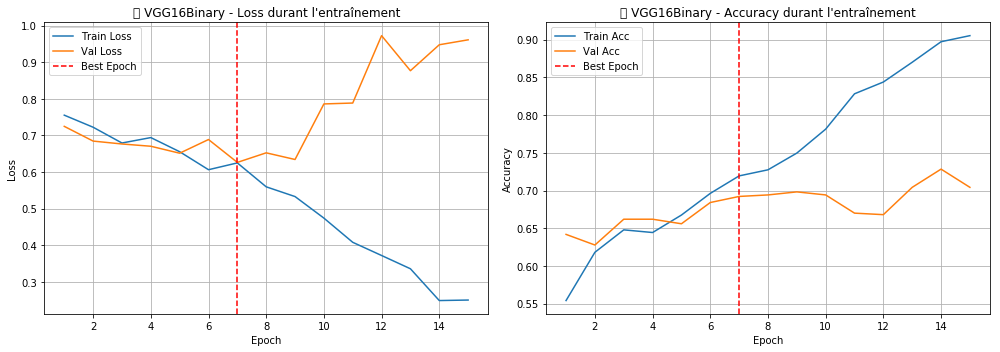

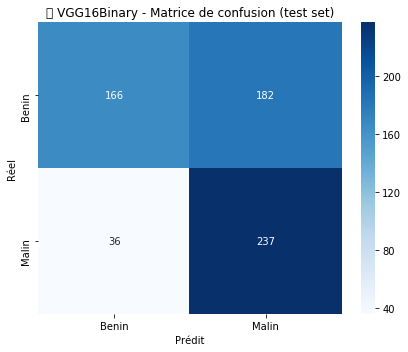

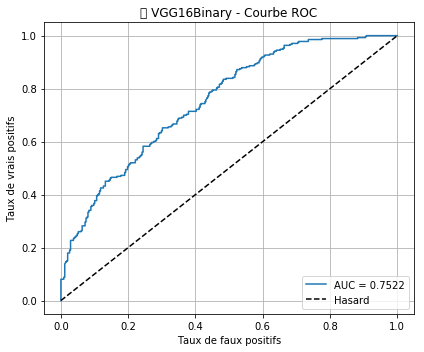


✅ Tous les résultats ont été enregistrés dans : evals_vgg16/eval_20250518_022324


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import os
import glob
from datetime import datetime

# === Charger ton modèle personnalisé (à inclure si pas déjà dans la cellule)
from torchvision.models import vgg16

class VGG16Binary(nn.Module):
    def __init__(self, pretrained=False, dropout_rate=0.3):
        super().__init__()
        self.model = vgg16(pretrained=pretrained)
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(num_ftrs, 1)
        )

    def forward(self, x):
        return self.model(x)

# === Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 🔍 Trouver le dernier modèle
model_dirs = sorted(glob.glob("runs_vgg16_dropout/vgg16_d30_run_*/model"))
assert model_dirs, "Aucun dossier de modèle trouvé"
last_run_dir = model_dirs[-1]
best_model_path = os.path.join(last_run_dir, "best_model.pth")

# 📂 Création du dossier d’évaluation horodaté
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
eval_dir = os.path.join("evals_vgg16", f"eval_{timestamp}")
os.makedirs(eval_dir, exist_ok=True)

# 📈 Historique
epochs = range(1, len(train_losses) + 1)
opt_epoch = val_losses.index(min(val_losses)) + 1
end_val_loss = val_losses[-1]
end_val_acc = val_accs[-1]
opt_val_loss = val_losses[opt_epoch - 1]
opt_val_acc = val_accs[opt_epoch - 1]

# === 🔥 Chargement du modèle
model_best = VGG16Binary().to(device)
model_best.load_state_dict(torch.load(best_model_path, map_location=device))
model_best.eval()

# === 📊 Prédictions
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1, 1).float()

        outputs = model_best(inputs)
        probas = torch.sigmoid(outputs)
        preds = (probas > 0.5).float()

        y_true.extend(labels.cpu().numpy().flatten())
        y_pred.extend(preds.cpu().numpy().flatten())
        y_scores.extend(probas.cpu().numpy().flatten())

# === 📄 Rapport & Matrice de confusion
report = classification_report(y_true, y_pred, digits=4)
conf_matrix = confusion_matrix(y_true, y_pred)

print("\n📄 Rapport de classification :")
print(report)
print("\n📊 Matrice de confusion :")
print(conf_matrix)

# === 💾 Rapport texte
with open(os.path.join(eval_dir, "rapport.txt"), "w") as f:
    f.write("🎯 Résumé du modèle : VGG16Binary\n")
    f.write(f"Dossier modèle : {last_run_dir}\n")
    f.write(f"Meilleure epoch : {opt_epoch}\n")
    f.write(f"Val Acc finale : {end_val_acc:.4f} | optimale : {opt_val_acc:.4f}\n")
    f.write(f"Val Loss finale : {end_val_loss:.4f} | optimale : {opt_val_loss:.4f}\n\n")
    f.write("📄 Rapport de classification :\n")
    f.write(report + "\n")
    f.write("📊 Matrice de confusion :\n")
    f.write(np.array2string(conf_matrix))

# === 📉 Courbes entraînement
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.axvline(opt_epoch, color='r', linestyle='--', label='Best Epoch')
plt.title("📉 VGG16Binary - Loss durant l'entraînement")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.axvline(opt_epoch, color='r', linestyle='--', label='Best Epoch')
plt.title("📈 VGG16Binary - Accuracy durant l'entraînement")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(eval_dir, "courbes_entraînement_VGG16Binary.png"))
plt.show()

# === 🔲 Matrice de confusion heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benin", "Malin"], yticklabels=["Benin", "Malin"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("🔲 VGG16Binary - Matrice de confusion (test set)")
plt.tight_layout()
plt.savefig(os.path.join(eval_dir, "matrice_confusion_VGG16Binary.png"))
plt.show()

# === 🔵 ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
auc_score = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Hasard")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("📈 VGG16Binary - Courbe ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(eval_dir, "roc_curve_VGG16Binary.png"))
plt.show()

print(f"\n✅ Tous les résultats ont été enregistrés dans : {eval_dir}")
